# Basal_Activity_Transformation

In [ ]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

sns.set_style('whitegrid')

## Data preperation

### Load data from Data_Basal_Expression folder

In [ ]:
precise1k = load_json_model('Data_Basal_Expression/p1k.json.gz')

In [ ]:
TF_Gene_binary_matrix_p1k = pd.read_csv('./Data_Basal_Expression/gene_tf_p1k_regulon.csv', index_col=0)

In [ ]:
gene_presence_matrix = pd.read_csv('./Data_Basal_Expression/gene_presence_matrix.csv', index_col=0)

In [ ]:
iM_table = pd.read_csv('./Data_Basal_Expression/iM_table.csv', index_col=0)

### Generate Binarized gene presence matrix

In [ ]:
import pandas as pd

def map_and_rename_columns(df1, df2):

     # Convert df2 columns to the same type as df1 index
    df2.columns = df2.columns.astype(df1.index.dtype)

    # Ensure df1's index matches the columns in df2
    if not all(df1.index == range(len(df2.columns))):
        raise ValueError("The index of df1 must match the column order in df2.")

    # Create a mapping dictionary
    mapping_dict = dict(zip(df1.index, df1['name']))
    
    # Rename the columns in df2
    df2_renamed = df2.rename(columns=mapping_dict)

    # Convert True/False to 1/0
    df2_converted = df2_renamed.applymap(lambda x: 1 if x is True else 0 if x is False else x)

    return df2_converted

In [ ]:
Binarized_renamed_gene_presence_matrix = map_and_rename_columns(iM_table, gene_presence_matrix)

### Filter iM direction file to only the iMs with direction annotated

In [ ]:
import pandas as pd

# File path for Excel file
file_path = 'Data_Basal_Expression/iM_Directions.xlsx'

# Read the Excel file
try:
    df = pd.read_excel(file_path)

    # Select the required columns
    selected_columns = ['name', 'regulator_readable', '0_direction']

    # Check if these columns exist in the dataframe
    if not all(col in df.columns for col in selected_columns):
        raise ValueError("One or more required columns are missing in the Excel file.")

    # Filter the rows based on the following conditions:
    # 1. '0_direction' is not empty.
    # 2. 'regulator_readable' does not contain 'and' or 'or'.
    # 3. 'regulator_readable' is not empty.
    filtered_df = df[selected_columns]
    filtered_df = filtered_df[
        filtered_df['0_direction'].notna() &
        filtered_df['regulator_readable'].notna()
    ]
    
    # Save the filtered data to a new DataFrame
    filtered_df.to_csv('Data_Basal_Expression/filtered_iM_Directions.csv', index=False)
    filtered_iM_Directions = filtered_df
    print("Filtered data saved to 'filtered_iM_Directions.csv'.")

except Exception as e:
    print(f"An error occurred: {e}")

Filtered data saved to 'filtered_iM_Directions.csv'.


### Initiate variables

In [ ]:
PRECISE_1K_X_basal = precise1k.X

In [ ]:
PRECISE_1K_log_tpm = precise1k.log_tpm

In [ ]:
PRECISE_1K_X = precise1k.X

In [ ]:
PRECISE_1K_M = precise1k.M

### Merge iM gene membership with iM direction dataframe

In [ ]:
def find_regulated_genes(regulator, tf_gene_matrix):
    # Convert regulator to lowercase for case-insensitive comparison
    regulator = regulator.lower()
    regulated_genes = []

    # Iterate through the columns and match the regulator
    for col in tf_gene_matrix.columns:
        if col.lower() == regulator:
            # Get the genes where the value in this column is 1
            regulated_genes = tf_gene_matrix.index[tf_gene_matrix[col] == 1].astype(str).tolist()
            break

    return ','.join(regulated_genes)

In [ ]:
filtered_iM_Directions['genes'] = filtered_iM_Directions['name'].apply(
    lambda x: find_regulated_genes(x, Binarized_renamed_gene_presence_matrix))

filtered_iM_Directions_with_gene = filtered_iM_Directions

In [ ]:
filtered_iM_Directions_with_gene['0_direction'] = filtered_iM_Directions_with_gene['0_direction'].replace({'+': 1, '-': -1})

In [ ]:
filtered_iM_Directions_with_gene

name              regulator_readable  0_direction  \
0          RpoS                            RpoS           -1   
1       FlhDC-2                           FlhDC           -1   
2          FliA                            FliA           -1   
3         ppGpp                           ppGpp            1   
4         GadXW                   GadX and GadW           -1   
5    Pyrimidine                     PurR or UTP           -1   
6         Fnr-3                             Fnr           -1   
7         Fnr-1                             Fnr           -1   
8          ArcA                            ArcA            1   
9    Putrescine          RpoS and ArcA and PuuR           -1   
10          Lrp                             Lrp            1   
11        Crp-1                             Crp           -1   
12       Copper            CusR or CueR or HprR           -1   
13       Zinc-1             Zur or ZntR or CueR           -1   
14        Fur-1                             Fur            1   
15        Fnr-2                             Fnr           -1   
16   Thiamine-1            Thiamine diphosphate            1   
17       Purine                  PurR and ppGpp            1   
18        Crp-2                             Crp           -1   
19     Arginine                            ArgR            1   
20  Translation                            DksA           -1   
21     Glycerol                    Crp and GlpR           -1   
22   Cysteine-1                            CysB            1   
23      Maltose                            MalT           -1   
24   Methionine                            MetJ           -1   
25      FlhDC-1                           FlhDC            1   
26        Fur-2                             Fur           -1   
27    Glycolate  IHF and ArcA and PdhR and GlcC           -1   
28         gcvB                            gcvB           -1   
29      Capsule                           RcsAB           -1   
30       NtrC-1          RpoN and RpoS and NtrC           -1   
31    Glutamine                            NtrC           -1   

                                                genes  
0   b0186,b0325,b0329,b0384,b0453,b0456,b0581,b064...  
1   b1070,b1071,b1072,b1073,b1074,b1075,b1076,b107...  
2   b0250,b0763,b0764,b0765,b1070,b1071,b1082,b108...  
3   b0023,b0142,b0143,b0211,b0238,b0405,b0423,b046...  
4   b0485,b0486,b1492,b1493,b2217,b3491,b3506,b350...  
5   b0032,b0033,b0034,b0336,b0337,b0945,b1062,b249...  
6   b0836,b0894,b0904,b1223,b1256,b1445,b1474,b154...  
7   b0621,b0894,b0895,b0896,b0903,b1256,b1257,b125...  
8   b0113,b0118,b0124,b0312,b0313,b0314,b0330,b034...  
9     b1296,b1297,b1298,b1299,b1300,b1301,b1302,b4742  
10  b0072,b0077,b0078,b0381,b0861,b0863,b0929,b118...  
11  b0129,b0306,b0328,b0380,b0445,b0681,b0791,b100...  
12  b0123,b0484,b0570,b0571,b0572,b0573,b0574,b057...  
13  b0123,b0296,b0484,b1178,b1856,b1857,b1858,b185...  
14  b0153,b0583,b0584,b0585,b0586,b0588,b0589,b059...  
15  b0007,b0375,b0621,b0715,b0824,b0825,b0837,b087...  
16  b0068,b2103,b2104,b3990,b3991,b3992,b3993,b399...  
17  b0522,b0523,b0529,b1062,b1131,b1623,b1660,b168...  
18  b1415,b1426,b1817,b1818,b1819,b1820,b2091,b209...  
19  b0032,b0033,b0034,b0272,b0273,b0709,b0860,b086...  
20  b0169,b0170,b1089,b1717,b2185,b2606,b2607,b260...  
21  b1199,b1200,b2239,b2240,b2241,b2242,b2243,b342...  
22  b0828,b0829,b0830,b1287,b1729,b1917,b1918,b191...  
23  b3416,b3417,b3571,b4032,b4033,b4034,b4035,b403...  
24  b0197,b0198,b0199,b0260,b0261,b0599,b0600,b149...  
25  b1043,b1044,b1071,b1072,b1073,b1074,b1075,b107...  
26  b0150,b0151,b0152,b0153,b0468,b0585,b0588,b058...  
27                b2975,b2976,b2977,b2979,b4467,b4468  
28  b0218,b0278,b0279,b0294,b0326,b0498,b0499,b050...  
29  b0403,b0439,b0527,b0581,b1115,b1951,b2028,b204...  
30  b0450,b0451,b1218,b1483,b1484,b1485,b1486,b148...  
31  b0654,b0809,b0810,b0811,b2309,b2310,b3744,b386...

### Select the iMs with direction from original A matrix

In [ ]:
def subset_dataframe_by_index(source_df, index_df, index_column):
    
    # Extract the list of names to be used as indexes
    index_list = index_df[index_column].tolist()

    # Filter the source dataframe using this list
    subset_df = source_df.loc[source_df.index.intersection(index_list)]
    return subset_df

In [ ]:
PRECISE_1K_A_filtered = subset_dataframe_by_index(precise1k.A, filtered_iM_Directions, 'name')
PRECISE_1K_A_filtered

p1k_00001  p1k_00002  p1k_00003  p1k_00004  p1k_00005  p1k_00006  \
Translation   0.201055  -0.201055  -8.162122  -8.046208   1.633678   1.973262   
FlhDC-2      -0.329000   0.329000  -5.319409  -5.196873  -7.144849  -6.758991   
Glutamine     0.027685  -0.027685  -2.820199  -3.081529  -0.012002  -0.366692   
Zinc-1       -0.016763   0.016763   0.150069   0.162413  20.954513  20.862095   
Methionine   -0.032605   0.032605   9.517643   7.090895   0.419788   0.455534   
Glycerol     -0.069219   0.069219   1.768178   1.862046  -0.304792  -0.331246   
Lrp          -0.095237   0.095237  -9.790644 -10.223677   1.226382   1.045725   
RpoS          0.249722  -0.249722  18.259383  18.741579  -1.598087  -1.858328   
Fur-1        -0.102584   0.102584  11.940410  10.888554  -4.733862  -6.011827   
Fur-2        -0.090960   0.090960   5.141262   5.298588  -1.376197  -3.195555   
Fnr-1         0.167948  -0.167948   2.337920   3.404941   0.305883   0.537992   
Pyrimidine    0.061058  -0.061058 -13.286760 -16.006026   1.139048   0.766886   
ArcA         -0.133833   0.133833  -3.694200  -3.902144  -0.434826  -0.607569   
Crp-1         0.133712  -0.133712  -1.801538  -1.789236  -1.277517  -0.747888   
NtrC-1       -0.091440   0.091440   3.161379   3.942562   0.678206   0.325864   
Fnr-3         0.152205  -0.152205  -1.289334  -1.215070   1.827003   1.388307   
Copper       -0.129854   0.129854 -13.232673 -13.326436  -9.481635  -8.245451   
Thiamine-1   -0.400035   0.400035   4.708361   4.772250  -0.407168  -0.494967   
FliA          0.209234  -0.209234   0.427631   0.841559  -0.783928  -0.935524   
Crp-2         0.043984  -0.043984 -11.224692 -13.024489  -0.154498   0.247732   
Cysteine-1   -0.142394   0.142394   3.946424   5.172369   2.212724   1.993225   
Capsule      -0.267269   0.267269   3.261450   3.718946  -0.241341   0.465076   
FlhDC-1       0.581518  -0.581518   3.141270   3.764473   1.355894   0.727676   
Putrescine   -0.360141   0.360141  -6.393848  -5.644166  -2.076782  -2.897627   
ppGpp        -0.147762   0.147762 -15.748257 -16.287192   1.145041   1.371213   
Glycolate     0.083551  -0.083551   0.982557   1.046458   2.266833   2.843816   
Arginine     -0.150136   0.150136  -8.292249 -10.639110   2.233493   1.825039   
Fnr-2         0.096985  -0.096985  -1.091953  -0.892069  -0.094362   0.354882   
GadXW         0.012215  -0.012215   7.410061   7.468732   1.119182   0.465940   
Purine       -0.019501   0.019501  -4.421612  -6.021875   1.041196   0.861770   
Maltose       0.071697  -0.071697  -8.274651  -8.217184  -2.162792  -1.028005   
gcvB          0.057607  -0.057607  -3.387896  -3.921555  -0.403448   0.519652   

             p1k_00007  p1k_00008  p1k_00009  p1k_00010  ...  p1k_01046  \
Translation  -8.058080  -6.272859  -1.536470  -1.828831  ...   2.416670   
FlhDC-2      -5.930140  -5.934485  -1.775148  -3.070194  ...   4.303118   
Glutamine    -2.240582  -2.199874   0.377880   0.422397  ...  -3.687306   
Zinc-1        0.912177   4.707154   4.544531   5.385417  ...   3.577091   
Methionine   13.421768  13.471319   2.264592   2.347852  ...  -1.322773   
Glycerol      0.915502   0.883608   0.088181   0.158486  ...   1.873356   
Lrp         -13.601969 -13.177082  -0.549406  -0.625931  ...   1.595397   
RpoS         18.403805  17.014813   2.042839   3.095533  ... -34.444082   
Fur-1        11.992649  12.461247  17.679290  17.414859  ...  -5.427233   
Fur-2         4.906864   4.572939   5.999135   5.851256  ...  -7.210383   
Fnr-1         1.789203   1.338881  -2.950675  -3.054657  ...  -0.256619   
Pyrimidine   -9.121460  -8.340634  -0.656772  -0.543222  ...  -3.428636   
ArcA         -3.805504  -4.061716  -2.724333  -2.569072  ...   1.787593   
Crp-1        -1.389024  -1.814665  -0.312464  -0.155540  ...  -1.674214   
NtrC-1        2.923966   2.647147   0.316599   0.601814  ...  -0.470178   
Fnr-3        -0.490954  -0.871171  -1.950010  -1.690065  ...   2.493444   
Copper      -13.209856 -13.135922  -3.730350  -3.861064  ... -12

### Adjust A values based on direction

In [ ]:
PRECISE_1K_A_filtered

p1k_00001  p1k_00002  p1k_00003  p1k_00004  p1k_00005  p1k_00006  \
Translation   0.201055  -0.201055  -8.162122  -8.046208   1.633678   1.973262   
FlhDC-2      -0.329000   0.329000  -5.319409  -5.196873  -7.144849  -6.758991   
Glutamine     0.027685  -0.027685  -2.820199  -3.081529  -0.012002  -0.366692   
Zinc-1       -0.016763   0.016763   0.150069   0.162413  20.954513  20.862095   
Methionine   -0.032605   0.032605   9.517643   7.090895   0.419788   0.455534   
Glycerol     -0.069219   0.069219   1.768178   1.862046  -0.304792  -0.331246   
Lrp          -0.095237   0.095237  -9.790644 -10.223677   1.226382   1.045725   
RpoS          0.249722  -0.249722  18.259383  18.741579  -1.598087  -1.858328   
Fur-1        -0.102584   0.102584  11.940410  10.888554  -4.733862  -6.011827   
Fur-2        -0.090960   0.090960   5.141262   5.298588  -1.376197  -3.195555   
Fnr-1         0.167948  -0.167948   2.337920   3.404941   0.305883   0.537992   
Pyrimidine    0.061058  -0.061058 -13.286760 -16.006026   1.139048   0.766886   
ArcA         -0.133833   0.133833  -3.694200  -3.902144  -0.434826  -0.607569   
Crp-1         0.133712  -0.133712  -1.801538  -1.789236  -1.277517  -0.747888   
NtrC-1       -0.091440   0.091440   3.161379   3.942562   0.678206   0.325864   
Fnr-3         0.152205  -0.152205  -1.289334  -1.215070   1.827003   1.388307   
Copper       -0.129854   0.129854 -13.232673 -13.326436  -9.481635  -8.245451   
Thiamine-1   -0.400035   0.400035   4.708361   4.772250  -0.407168  -0.494967   
FliA          0.209234  -0.209234   0.427631   0.841559  -0.783928  -0.935524   
Crp-2         0.043984  -0.043984 -11.224692 -13.024489  -0.154498   0.247732   
Cysteine-1   -0.142394   0.142394   3.946424   5.172369   2.212724   1.993225   
Capsule      -0.267269   0.267269   3.261450   3.718946  -0.241341   0.465076   
FlhDC-1       0.581518  -0.581518   3.141270   3.764473   1.355894   0.727676   
Putrescine   -0.360141   0.360141  -6.393848  -5.644166  -2.076782  -2.897627   
ppGpp        -0.147762   0.147762 -15.748257 -16.287192   1.145041   1.371213   
Glycolate     0.083551  -0.083551   0.982557   1.046458   2.266833   2.843816   
Arginine     -0.150136   0.150136  -8.292249 -10.639110   2.233493   1.825039   
Fnr-2         0.096985  -0.096985  -1.091953  -0.892069  -0.094362   0.354882   
GadXW         0.012215  -0.012215   7.410061   7.468732   1.119182   0.465940   
Purine       -0.019501   0.019501  -4.421612  -6.021875   1.041196   0.861770   
Maltose       0.071697  -0.071697  -8.274651  -8.217184  -2.162792  -1.028005   
gcvB          0.057607  -0.057607  -3.387896  -3.921555  -0.403448   0.519652   

             p1k_00007  p1k_00008  p1k_00009  p1k_00010  ...  p1k_01046  \
Translation  -8.058080  -6.272859  -1.536470  -1.828831  ...   2.416670   
FlhDC-2      -5.930140  -5.934485  -1.775148  -3.070194  ...   4.303118   
Glutamine    -2.240582  -2.199874   0.377880   0.422397  ...  -3.687306   
Zinc-1        0.912177   4.707154   4.544531   5.385417  ...   3.577091   
Methionine   13.421768  13.471319   2.264592   2.347852  ...  -1.322773   
Glycerol      0.915502   0.883608   0.088181   0.158486  ...   1.873356   
Lrp         -13.601969 -13.177082  -0.549406  -0.625931  ...   1.595397   
RpoS         18.403805  17.014813   2.042839   3.095533  ... -34.444082   
Fur-1        11.992649  12.461247  17.679290  17.414859  ...  -5.427233   
Fur-2         4.906864   4.572939   5.999135   5.851256  ...  -7.210383   
Fnr-1         1.789203   1.338881  -2.950675  -3.054657  ...  -0.256619   
Pyrimidine   -9.121460  -8.340634  -0.656772  -0.543222  ...  -3.428636   
ArcA         -3.805504  -4.061716  -2.724333  -2.569072  ...   1.787593   
Crp-1        -1.389024  -1.814665  -0.312464  -0.155540  ...  -1.674214   
NtrC-1        2.923966   2.647147   0.316599   0.601814  ...  -0.470178   
Fnr-3        -0.490954  -0.871171  -1.950010  -1.690065  ...   2.493444   
Copper      -13.209856 -13.135922  -3.730350  -3.861064  ... -12

In [ ]:
def Basal_adjusted_based_on_direction(precise_df, directions_df, index_column, direction_column):
    
    # Create a copy of precise_df to avoid modifying the original DataFrame
    adjusted_df = precise_df.copy()

    # Ensure the index of directions_df is set to index_column
    directions_df = directions_df.set_index(index_column)

    # Iterate over the rows in the copied DataFrame
    for gene in adjusted_df.index:
        if gene in directions_df.index:
            direction = directions_df.loc[gene, direction_column]
            
            # Adjust values based on the direction
            if direction == 1:

                quantile_95 = adjusted_df.loc[gene].quantile(0.95)
                adjusted_df.loc[gene] = adjusted_df.loc[gene] - quantile_95
                adjusted_df.loc[gene] = -adjusted_df.loc[gene]

            elif direction == -1:

                quantile_5 = adjusted_df.loc[gene].quantile(0.05)
                adjusted_df.loc[gene] = adjusted_df.loc[gene] - quantile_5
                
    return adjusted_df

In [ ]:
PRECISE_1K_A_filtered_basal = Basal_adjusted_based_on_direction(PRECISE_1K_A_filtered, filtered_iM_Directions, 'name', '0_direction')

Lrp
1.2491635809746833
Fur-1
12.422983389272915
ArcA
3.438099921835104
Thiamine-1
4.134566301799591
Cysteine-1
4.650329034391105
FlhDC-1
14.693814392511419
ppGpp
8.005178180293754
Arginine
2.1325915252832837
Purine
1.3253376038828713


In [ ]:
PRECISE_1K_A_filtered_basal

p1k_00001  p1k_00002  p1k_00003  p1k_00004  p1k_00005  p1k_00006  \
Translation  12.626769  12.224659   4.263592   4.379505  14.059392  14.398975   
FlhDC-2       8.215812   8.873812   3.225403   3.347939   1.399964   1.785821   
Glutamine     9.433193   9.377823   6.585310   6.323979   9.393506   9.038816   
Zinc-1        1.377010   1.410536   1.543843   1.556187  22.348286  22.255868   
Methionine   14.272834  14.338044  23.823082  21.396335  14.725227  14.760973   
Glycerol      0.734132   0.872571   2.571529   2.665398   0.498559   0.472105   
Lrp           1.344401   1.153927  11.039808  11.472840   0.022782   0.203438   
RpoS         33.271528  32.772084  51.281189  51.763385  31.423719  31.163478   
Fur-1        12.525568  12.320399   0.482573   1.534429  17.156846  18.434810   
Fur-2        13.604603  13.786523  18.836825  18.994151  12.319366  10.500008   
Fnr-1         2.577203   2.241308   4.747176   5.814197   2.715139   2.947247   
Pyrimidine   19.286980  19.164864   5.939162   3.219896  20.364970  19.992808   
ArcA          3.571933   3.304267   7.132300   7.340243   3.872926   4.045669   
Crp-1         3.679055   3.411630   1.743804   1.756106   2.267825   2.797455   
NtrC-1        5.643658   5.826539   8.896478   9.677661   6.413304   6.060962   
Fnr-3         2.517730   2.213319   1.076190   1.150454   4.192528   3.753832   
Copper       14.420948  14.680656   1.318129   1.224366   5.069167   6.305351   
Thiamine-1    4.534601   3.734531  -0.573795  -0.637684   4.541734   4.629534   
FliA          1.509197   1.090729   1.727594   2.141522   0.516035   0.364439   
Crp-2        15.709517  15.621550   4.440842   2.641045  15.511036  15.913266   
Cysteine-1    4.792723   4.507935   0.703905  -0.522040   2.437605   2.657104   
Capsule       0.979197   1.513735   4.507917   4.965412   1.005126   1.711542   
FlhDC-1      14.112296  15.275333  11.552545  10.929341  13.337921  13.966138   
Putrescine   13.404386  14.124669   7.370680   8.120361  11.687745  10.866901   
ppGpp         8.152940   7.857416  23.753435  24.292370   6.860137   6.633965   
Glycolate     5.027619   4.860518   5.926626   5.990527   7.210901   7.787885   
Arginine      2.282728   1.982455  10.424841  12.771702  -0.100902   0.307553   
Fnr-2         1.268276   1.074306   0.079338   0.279222   1.076929   1.526173   
GadXW        17.760235  17.735806  25.158082  25.216752  18.867202  18.213960   
Purine        1.344839   1.305837   5.746949   7.347212   0.284142   0.463568   
Maltose      10.056627   9.913233   1.710279   1.767747   7.822138   8.956925   
gcvB          3.774805   3.659592   0.329302  -0.204356   3.313751   4.236851   

             p1k_00007  p1k_00008  p1k_00009  p1k_00010  ...  p1k_01046  \
Translation   4.367633   6.152855  10.889244  10.596883  ...  14.842384   
FlhDC-2       2.614672   2.610327   6.769664   5.474618  ...  12.847930   
Glutamine     7.164926   7.205634   9.783388   9.827906  ...   5.718202   
Zinc-1        2.305951   6.100927   5.938304   6.779190  ...   4.970864   
Methionine   27.727207  27.776758  16.570031  16.653291  ...  12.982666   
Glycerol      1.718854   1.686959   0.891533   0.961837  ...   2.676707   
Lrp          14.851132  14.426246   1.798570   1.875095  ...  -0.346233   
RpoS         51.425611  50.036619  35.064645  36.117339  ...  -1.422276   
Fur-1         0.430335  -0.038264  -5.256307  -4.991876  ...  17.850216   
Fur-2        18.602427  18.268502  19.694698  19.546818  ...   6.485180   
Fnr-1         4.198459   3.748137  -0.541419  -0.645401  ...   2.152637   
Pyrimidine   10.104462  10.885288  18.569150  18.682700  ...  15.797286   
ArcA          7.243604   7.499816   6.162433   6.007172  ...   1.650507   
Crp-1         2.156319   1.730677   3.232879   3.389803  ...   1.871129   
NtrC-1        8.659065   8.382246   6.051697   6.336912  ...   5.264921   
Fnr-3         1.874571   1.494353   0.415514   0.675459  ...   4.858969   
Copper        1.340946   1.414880  10.820452  10.689738  ...   1

In [ ]:
def min_max_median(df):

    result_df = pd.DataFrame()
    result_df['Min'] = df.min(axis=1)
    result_df['Max'] = df.max(axis=1)
    result_df['Median'] = df.median(axis=1)
    result_df[df.columns[0]] = df.iloc[:, 0]

    # Sorting by the first column of the input DataFrame
    result_df = result_df.sort_values(by=df.columns[0], ascending=False)
    
    return result_df

In [ ]:
PRECISE_1K_A_filtered_basal_min_max_median = min_max_median(PRECISE_1K_A_filtered_basal)

In [ ]:
PRECISE_1K_A_filtered_basal_min_max_median

Min        Max     Median  p1k_00001
RpoS         -5.048291  61.298154  27.499869  33.271528
Pyrimidine   -3.377307  21.446740  10.260001  19.286980
GadXW        -1.566667  33.422380   9.686036  17.760235
Crp-2       -12.021710  29.249010  15.708985  15.709517
Copper       -2.674599  22.351310  12.703430  14.420948
Methionine   -4.676180  27.776758  12.676353  14.272834
FlhDC-1     -10.593834  17.588010  12.870343  14.112296
Fur-2       -11.870823  20.406715  12.534012  13.604603
Putrescine   -5.126939  20.927444   6.564190  13.404386
Translation -21.574281  34.489096  11.035105  12.626769
Fur-1        -5.739803  28.662232  15.181844  12.525568
Maltose      -2.001093  28.298613   5.832310  10.056627
Glutamine   -18.373966  15.226648   7.418726   9.433193
FlhDC-2      -3.521029  46.786693   9.486690   8.215812
ppGpp       -16.475537  54.783387  14.442697   8.152940
NtrC-1       -1.899090  40.860282   4.017331   5.643658
Glycolate    -3.656050  24.023901   3.830411   5.027619
Cysteine-1   -6.352350  28.628867   4.417797   4.792723
Thiamine-1   -1.384826  25.947527   5.787622   4.534601
gcvB         -3.812378  43.046648   5.535465   3.774805
Crp-1        -4.299028  39.329650   4.383808   3.679055
ArcA         -4.415077  33.333708   6.426087   3.571933
Fnr-1        -2.832417  31.466177   4.841075   2.577203
Fnr-3        -1.659704  27.372537   4.858969   2.517730
Arginine     -8.818439  22.647795   5.772023   2.282728
FliA         -4.917931  39.722711   3.005908   1.509197
Zinc-1       -2.132298  24.767242   2.341522   1.377010
Purine       -3.812447  27.116439   4.397194   1.344839
Lrp          -2.432179  30.185650   5.261002   1.344401
Fnr-2        -3.296205  29.301451   2.221075   1.268276
Capsule      -1.286712  49.146184   1.721101   0.979197
Glycerol     -0.838139  26.423648   1.932782   0.734132

### Adjust M values based on direction

In [ ]:
def subset_dataframe_by_index(source_df, index_df, index_column):
    
    # Extract the list of names to be used as indexes
    index_list = index_df[index_column].tolist()

    # Filter the source dataframe using this list
    subset_df = source_df.loc[source_df.index.intersection(index_list)]
    return subset_df

In [ ]:
PRECISE_1K_M_filtered = subset_dataframe_by_index(precise1k.M.T, filtered_iM_Directions, 'name')

In [ ]:
def Basal_adjusted_based_on_direction(precise_df, directions_df, index_column, direction_column):
    
    # Create a copy of precise_df to avoid modifying the original DataFrame
    adjusted_df = precise_df.copy()

    # Ensure the index of directions_df is set to index_column
    directions_df = directions_df.set_index(index_column)

    # Iterate over the rows in the copied DataFrame
    for gene in adjusted_df.index:
        if gene in directions_df.index:
            direction = directions_df.loc[gene, direction_column]
            
            # Adjust values based on the direction
            if direction == 1:
                adjusted_df.loc[gene] = -adjusted_df.loc[gene]
            elif direction == -1:
                adjusted_df.loc[gene] = adjusted_df.loc[gene]
                
    return adjusted_df

In [ ]:
PRECISE_1K_M_filtered_basal = Basal_adjusted_based_on_direction(PRECISE_1K_M_filtered, filtered_iM_Directions, 'name', '0_direction')

In [ ]:
PRECISE_1K_M_filtered_basal

b0002     b0003     b0004     b0005     b0006     b0007  \
Translation -0.002423 -0.001901 -0.002205  0.008573 -0.002293 -0.005062   
FlhDC-2     -0.017297 -0.004829 -0.004938  0.002009 -0.001754 -0.001023   
Glutamine   -0.006491 -0.011677 -0.008127 -0.016374  0.023500 -0.020130   
Zinc-1      -0.021498 -0.008961 -0.007227 -0.006712 -0.004151 -0.003351   
Methionine  -0.011306  0.009574  0.007125  0.001546 -0.004652  0.001977   
Glycerol    -0.003374 -0.010851 -0.009040 -0.002295  0.002150 -0.000994   
Lrp          0.008852 -0.005179 -0.008905 -0.009858  0.001969  0.002971   
RpoS        -0.014286  0.000513  0.004022  0.005093 -0.004144 -0.000541   
Fur-1        0.005662 -0.004261 -0.007001 -0.018348  0.013525  0.000491   
Fur-2       -0.001487  0.001103  0.000764 -0.000771  0.004604  0.002706   
Fnr-1        0.007151 -0.014437 -0.017103 -0.022271  0.005758  0.008727   
Pyrimidine  -0.001234  0.007327  0.008892  0.039984 -0.001620  0.004470   
ArcA         0.015277  0.000047 -0.002075 -0.005543  0.019749  0.004322   
Crp-1        0.003766 -0.003942 -0.006926 -0.017310  0.002440 -0.013520   
NtrC-1       0.007769 -0.000936 -0.002188 -0.020260 -0.012350  0.006437   
Fnr-3       -0.002955  0.010945  0.015517  0.003715 -0.009688  0.003024   
Copper      -0.007286 -0.000951 -0.003603  0.010064 -0.004798 -0.008198   
Thiamine-1  -0.015658 -0.012813 -0.007222 -0.012800  0.004415  0.003103   
FliA         0.010358 -0.005430 -0.005521 -0.001720 -0.000076 -0.000733   
Crp-2        0.018493  0.015533  0.015460  0.006244  0.002298 -0.000343   
Cysteine-1  -0.015532 -0.007218 -0.002800  0.002458  0.001574  0.008466   
Capsule     -0.001483 -0.006294 -0.006316 -0.006826 -0.002078 -0.004008   
FlhDC-1     -0.030678 -0.007302 -0.007142  0.009638 -0.000139  0.001747   
Putrescine   0.038292 -0.008806 -0.008042 -0.003074 -0.003600 -0.004714   
ppGpp        0.010785  0.018482  0.015327  0.015656  0.011908  0.027975   
Glycolate    0.000521 -0.009331 -0.008178 -0.019672 -0.002272 -0.004536   
Arginine    -0.000229 -0.004537 -0.006168 -0.002243 -0.008376 -0.001634   
Fnr-2       -0.003953 -0.004584  0.000457 -0.001785 -0.012329  0.082239   
GadXW        0.014159  0.007007  0.009603  0.011356 -0.001525 -0.001677   
Purine      -0.016418  0.015303  0.015251  0.006428  0.002478 -0.005411   
Maltose      0.028825 -0.000203 -0.002623  0.009332 -0.000915 -0.014304   
gcvB        -0.006679 -0.016328 -0.008647  0.018798  0.003860 -0.002380   

                b0008     b0009     b0010     b0011  ...     b4740     b4742  \
Translation  0.009543 -0.006189  0.012922 -0.007529  ... -0.006247 -0.004800   
FlhDC-2     -0.003526  0.001384 -0.004706  0.001765  ...  0.006853  0.002964   
Glutamine   -0.005113  0.003328 -0.020974 -0.019362  ...  0.031448  0.008001   
Zinc-1      -0.004119  0.002511 -0.000081 -0.001853  ...  0.005137  0.005138   
Methionine   0.003387 -0.003885 -0.003016 -0.010640  ... -0.018927 -0.009931   
Glycerol    -0.000841  0.002206  0.004800 -0.000546  ... -0.000563 -0.010660   
Lrp          0.012454  0.006012  0.002787 -0.000125  ...  0.081200 -0.001117   
RpoS        -0.005576 -0.011164 -0.013104 -0.013501  ...  0.000612 -0.004532   
Fur-1        0.002276  0.001062  0.001099  0.001255  ...  0.000203  0.016048   
Fur-2        0.003036  0.003216  0.004222  0.003308  ... -0.003683 -0.008300   
Fnr-1       -0.009846 -0.004634 -0.001911 -0.010754  ...  0.022187 -0.029752   
Pyrimidine   0.002398 -0.002745  0.011327 -0.004267  ... -0.006758 -0.007095   
ArcA         0.002438  0.013823 -0.001412  0.005941  ... -0.023944 -0.029798   
Crp-1       -0.005164  0.007258 -0.016490  0.013024  ... -0.010680  0.000817   
NtrC-1      -0.011458 -0.009540 -0.006019  0.002340  ...  0.021419 -0.021665   
Fnr-3       -0.000715 -0.007831  0.007395  0.001656  ... -0.004798  0.000403   
Copper      -0.001371 -0.004318 -0.004162 -0.004249  ... -0.000373  0.006080   
Thiamine-1   0.004652  0.003040  0.018075  0.001894  ...  0.003910  0.003888   
FliA         0.00093

### Get Basal M and A

In [ ]:
def update_source_dataframe(source_df, subset_df):
    # Ensure the indexes match to avoid potential errors
    if not subset_df.index.isin(source_df.index).all():
        raise ValueError("All indexes in subset_df must be present in source_df.")

    # Update the source_df with values from subset_df
    for index, row in subset_df.iterrows():
        source_df.loc[index] = row

    return source_df

In [ ]:
PRECISE_1K_M_basal = update_source_dataframe(precise1k.M.T, PRECISE_1K_M_filtered_basal).T

In [ ]:
PRECISE_1K_M_basal

Sugar Diacid  Translation      ygdT      OxyR   FlhDC-2  \
b0002     -0.005367    -0.002423  0.010140 -0.001362 -0.017297   
b0003      0.006212    -0.001901  0.007207  0.000073 -0.004829   
b0004      0.010600    -0.002205  0.004961 -0.002289 -0.004938   
b0005      0.011520     0.008573  0.020449 -0.003123  0.002009   
b0006      0.003482    -0.002293 -0.010146  0.140794 -0.001754   
...             ...          ...       ...       ...       ...   
b4747     -0.003644     0.018245 -0.003134  0.004992 -0.000873   
b4748      0.010023    -0.030343 -0.000578 -0.002526 -0.000906   
b4751      0.001082     0.013560  0.010030 -0.022409  0.006737   
b4755     -0.002204    -0.006527  0.003732 -0.000946 -0.009858   
b4756      0.002046    -0.007253  0.013169 -0.001936  0.004338   

       Osmoprotectant  Glutamine  Sialic Acid      yqhI  ROS TALE Amp  ...  \
b0002        0.008631  -0.006491     0.092469 -0.010978     -0.003400  ...   
b0003       -0.003186  -0.011677     0.082103  0.011074     -0.004679  ...   
b0004       -0.005587  -0.008127     0.080888  0.007511      0.003887  ...   
b0005       -0.026382  -0.016374     0.022484  0.007903      0.017561  ...   
b0006        0.000974   0.023500    -0.017665  0.006247     -0.005761  ...   
...               ...        ...          ...       ...           ...  ...   
b4747       -0.021262  -0.012556     0.036707 -0.062935      0.016316  ...   
b4748        0.000805   0.007411    -0.021330 -0.013622     -0.034542  ...   
b4751       -0.012387  -0.002341    -0.010584 -0.015837      0.003776  ...   
b4755        0.010553  -0.022747     0.003496  0.530162      0.000412  ...   
b4756       -0.007156   0.013021    -0.011346  0.016958      0.014252  ...   

       Tryptophanase  crp KO-2  cyoB/ndh/nuoB KO-2   tpiA KO  Phage Shock  \
b0002      -0.012070 -0.008812            0.004996  0.008216    -0.002720   
b0003       0.006683 -0.017798            0.000964  0.003273     0.010018   
b0004       0.008132 -0.018105           -0.007763  0.009103    -0.002566   
b0005      -0.000139  0.001437            0.001827 -0.008113     0.065835   
b0006       0.017025  0.005473           -0.002252  0.002807    -0.030303   
...              ...       ...                 ...       ...          ...   
b4747       0.002969 -0.012892            0.024815 -0.000077    -0.004676   
b4748       0.004057 -0.001059           -0.007595  0.002024     0.001573   
b4751      -0.005873 -0.000560            0.008653  0.005759     0.029820   
b4755       0.024388  0.003566            0.004696 -0.003552     0.002161   
b4756      -0.035027 -0.035403           -0.033315  0.012985    -0.012235   

       Glyoxylate  CCK-PGI Del   Acetate   Ile/Val      UC-8  
b0002    0.007874    -0.004350 -0.013319  0.009296  0.000891  
b0003    0.002132    -0.005826 -0.010836 -0.066654 -0.003513  
b0004   -0.007120    -0.005676 -0.002164 -0.060155 -0.007025  
b0005   -0.019238    -0.001622 -0.009303 -0.069669 -0.004241  
b0006    0.000805     0.028367  0.018293 -0.018444 -0.033624  
...           ...          ...       ...       ...       ...  
b4747    0.015222     0.011431  0.013733  0.011955  0.001203  
b4748   -0.029301    -0.007873  0.021424 -0.001528 -0.000353  
b4751   -0.004053     0.026769  0.020823  0.000414 -0.001453  
b4755    0.000556    -0.005656  0.021056  0.008180  0.021366  
b4756    0.025331    -0.047427  0.015525 -0.012791 -0.029001  

[4257 rows x 201 columns]

In [ ]:
PRECISE_1K_A_basal = update_source_dataframe(precise1k.A, PRECISE_1K_A_filtered_basal)

In [ ]:
PRECISE_1K_A_basal

p1k_00001  p1k_00002  p1k_00003  p1k_00004  p1k_00005  \
Sugar Diacid   0.048851  -0.048851   2.226245   2.238391   0.222740   
Translation   12.626769  12.224659   4.263592   4.379505  14.059392   
ygdT          -0.382475   0.382475   0.066040  -0.898701  -0.556961   
OxyR           0.130714  -0.130714   0.232581  -0.135165  -0.140487   
FlhDC-2        8.215812   8.873812   3.225403   3.347939   1.399964   
...                 ...        ...        ...        ...        ...   
Glyoxylate     0.344877  -0.344877   5.450515   5.444039  -0.641401   
CCK-PGI Del    0.077106  -0.077106  -0.260639   0.163570   1.030188   
Acetate        0.575197  -0.575197  -2.476044  -2.875184  -0.756414   
Ile/Val        0.226627  -0.226627   1.699217   1.678226  -1.167426   
UC-8           0.030095  -0.030095  10.531567  11.398028   0.181529   

              p1k_00006  p1k_00007  p1k_00008  p1k_00009  p1k_00010  ...  \
Sugar Diacid   0.383348   1.534940   1.480178   0.536021   0.167563  ...   
Translation   14.398975   4.367633   6.152855  10.889244  10.596883  ...   
ygdT          -1.523642   0.039413   0.002855   0.256867  -1.890067  ...   
OxyR          -0.435341  -0.788937  -1.333850   0.255054   0.464381  ...   
FlhDC-2        1.785821   2.614672   2.610327   6.769664   5.474618  ...   
...                 ...        ...        ...        ...        ...  ...   
Glyoxylate    -0.472477   5.557743   5.070821   0.423674   0.559522  ...   
CCK-PGI Del    1.220775  -0.049178   0.392918   1.611484   1.699807  ...   
Acetate       -0.251539  -1.737154  -1.652438  -1.304588  -1.319442  ...   
Ile/Val       -0.618004   2.100661   2.068120  -1.050492  -1.504338  ...   
UC-8           0.010180  10.096204   8.805000   1.234937   2.087628  ...   

              p1k_01046  p1k_01047  p1k_01048  p1k_01049  p1k_01050  \
Sugar Diacid   0.605951   3.969272   3.960774   3.431303   3.198403   
Translation   14.842384  11.237990  10.799403  10.933545  11.989203   
ygdT          -1.885401   0.689130   1.997418   2.177559   1.459224   
OxyR          -2.743285  -2.888544  -2.341820  -2.498864  -2.931448   
FlhDC-2       12.847930  10.171467  11.246254  10.385023  11.248115   
...                 ...        ...        ...        ...        ...   
Glyoxylate     1.180854   2.036347   2.514846   2.469912   2.064530   
CCK-PGI Del   -0.360018   0.689914   1.350155   0.510417   1.075789   
Acetate        1.637433   5.259582   6.259438   5.784253   4.928517   
Ile/Val        0.388348  -1.066533  -0.469043  -1.736812  -0.701636   
UC-8          -5.514625  -4.385007  -4.425120  -4.126450  -5.569304   

              p1k_01051  p1k_01052  p1k_01053  p1k_01054  p1k_01055  
Sugar Diacid   3.865406   1.095074   2.575524   1.850326   2.035736  
Translation   11.421004  17.684709  10.643565   7.823899   7.315195  
ygdT          -3.110064   4.336594   0.626609  -0.166365   0.539555  
OxyR          -2.693465  -1.690293  -3.056924  -3.575826  -2.316941  
FlhDC-2       10.406982  18.944318   4.259288  10.894074  11.646665  
...                 ...        ...        ...        ...        ...  
Glyoxylate     2.645660   0.830452   4.243346   2.047711   2.828812  
CCK-PGI Del    2.065799  -2.090274   0.143198  -0.551313   0.908994  
Acetate        4.221586   0.574095  12.177624  12.558275  12.767103  
Ile/Val       -0.657140   1.027797  -2.860252  -1.283872  -1.949882  
UC-8          -4.396786   5.594597  12.940747   8.799311   9.380663  

[201 rows x 1035 columns]

In [ ]:
PRECISE_1K_A_basal.to_csv('./Data_Basal_Expression/PRECISE_1K_A_basal.csv')

In [ ]:
PRECISE_1K_M_basal.to_csv('./Data_Basal_Expression/PRECISE_1K_M_basal.csv')

## Basal Correction

In [ ]:
# Initialize a dictionary to store DataFrames for each im_cur
accumulated_changes_dict = {}

for index, row in filtered_iM_Directions_with_gene.iterrows():
    im_cur = row['name']
    genes = row['genes'].split(',')  # Split the genes by comma
    direction = row['0_direction']

    # Print a line indicating the current im_cur being processed
    print(f"Processing: {im_cur}")
    
    # Initialize or retrieve the DataFrame for the current im_cur
    im_changes_df = accumulated_changes_dict.get(im_cur, pd.DataFrame(0, index=PRECISE_1K_X_basal.index, columns=PRECISE_1K_X_basal.columns))

    for gene_cur in genes:
        # Skip if the gene is not in the index
        if gene_cur not in PRECISE_1K_X_basal.index:
            continue

        # Calculate expression change due to the target iM
        A_vals_cur = PRECISE_1K_A_basal.loc[im_cur]
        M_vals_cur = PRECISE_1K_M_basal[im_cur]
        
        M_vals_cur_array = np.array([M_vals_cur.to_numpy()])
        A_vals_cur_array = np.array([A_vals_cur.to_numpy()])
        corr_expr = np.multiply(M_vals_cur_array.T, A_vals_cur_array)
        df_corr = pd.DataFrame(corr_expr, columns=precise1k.X.columns, index=precise1k.X.index)

        # Accumulate the changes in the DataFrame for im_cur
        change_in_expression = df_corr * direction
        im_changes_df.loc[gene_cur] += change_in_expression.loc[gene_cur]

    # Store the updated DataFrame back in the dictionary
    accumulated_changes_dict[im_cur] = im_changes_df

Processing: RpoS
Processing: FlhDC-2
Processing: FliA
Processing: ppGpp
Processing: GadXW
Processing: Pyrimidine
Processing: Fnr-3
Processing: Fnr-1
Processing: ArcA
Processing: Putrescine
Processing: Lrp
Processing: Crp-1
Processing: Copper
Processing: Zinc-1
Processing: Fur-1
Processing: Fnr-2
Processing: Thiamine-1
Processing: Purine
Processing: Crp-2
Processing: Arginine
Processing: Translation
Processing: Glycerol
Processing: Cysteine-1
Processing: Maltose
Processing: Methionine
Processing: FlhDC-1
Processing: Fur-2
Processing: Glycolate
Processing: gcvB
Processing: Capsule
Processing: NtrC-1
Processing: Glutamine


In [ ]:
# Combine all DataFrames to generate X_adjusted_accumulated
X_adjusted_accumulated = pd.concat(accumulated_changes_dict.values()).groupby(level=0).sum()

X_adjusted_accumulated

p1k_00001  p1k_00002  p1k_00003  p1k_00004  p1k_00005  p1k_00006  \
b0002   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b0003   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b0004   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b0005   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b0006   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
...          ...        ...        ...        ...        ...        ...   
b4747   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b4748   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b4751   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b4755   0.000000   0.000000    0.00000   0.000000   0.000000   0.000000   
b4756  -0.357482  -0.308833   -0.09099  -0.123236  -0.457033  -0.484268   

       p1k_00007  p1k_00008  p1k_00009  p1k_00010  ...  p1k_01046  p1k_01047  \
b0002   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b0003   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b0004   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b0005   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b0006   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
...          ...        ...        ...        ...  ...        ...        ...   
b4747   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b4748   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b4751   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b4755   0.000000   0.000000   0.000000   0.000000  ...    0.00000   0.000000   
b4756  -0.120336  -0.129722  -0.373154  -0.325478  ...   -0.67294  -0.589968   

       p1k_01048  p1k_01049  p1k_01050  p1k_01051  p1k_01052  p1k_01053  \
b0002   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b0003   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b0004   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b0005   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b0006   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
...          ...        ...        ...        ...        ...        ...   
b4747   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b4748   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b4751   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b4755   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
b4756  -0.503749  -0.589549  -0.623376  -0.243973  -0.459079  -0.513974   

       p1k_01054  p1k_01055  
b0002   0.000000    0.00000  
b0003   0.000000    0.00000  
b0004   0.000000    0.00000  
b0005   0.000000    0.00000  
b0006   0.000000    0.00000  
...          ...        ...  
b4747   0.000000    0.00000  
b4748   0.000000    0.00000  
b4751   0.000000    0.00000  
b4755   0.000000    0.00000  
b4756  -0.647629   -0.60298  

[4257 rows x 1035 columns]

In [ ]:
# Apply the accumulated changes to the base expression
PRECISE_1K_X_basal = precise1k.X + X_adjusted_accumulated

In [ ]:
# Apply the accumulated changes to the base expression
PRECISE_1K_log_tpm_basal = precise1k.log_tpm + X_adjusted_accumulated

In [ ]:
PRECISE_1K_X_basal.to_csv('./Data_Basal_Expression/PRECISE_1K_X_basal.csv')

In [ ]:
PRECISE_1K_log_tpm_basal.to_csv('./Data_Basal_Expression/PRECISE_1K_log_tpm_basal.csv')

## Characterization of corrrected/adjusted X

### Characterization of corrrected X

In [ ]:
def compare_variance_and_plot(precise1k_X, PRECISE_1K_X_basal):
    """
    Compares the variance of rows between two DataFrames, plots the distribution of the change in variance,
    outputs the number and percentage of genes with increased variance, and lists the top 10 genes with the greatest change in variance.

    Parameters:
    precise1k_X (pd.DataFrame): The original DataFrame.
    PRECISE_1K_X_basal (pd.DataFrame): The changed DataFrame.
    """

    # Ensure the indexes are the same for both DataFrames
    if not precise1k_X.index.equals(PRECISE_1K_X_basal.index):
        raise ValueError("The indexes of both DataFrames must match.")

    # Calculating variance for each row in both dataframes
    variance_precise1k_X = precise1k_X.var(axis=1)
    variance_PRECISE_1K_X_basal = PRECISE_1K_X_basal.var(axis=1)

    # Calculating the change in variance
    change_in_variance = variance_PRECISE_1K_X_basal - variance_precise1k_X

    # Identifying genes with increased variance
    increased_variance_genes = change_in_variance[change_in_variance > 0]
    number_of_genes_increased = len(increased_variance_genes)
    total_genes = precise1k_X.shape[0]
    percentage_increased = (number_of_genes_increased / total_genes) * 100

    print("Number of genes with increased variance:", number_of_genes_increased)
    print(f"Percentage of genes with increased variance: {percentage_increased:.2f}%")

    # Identifying top 10 genes with the greatest change in variance
    top_10_changed_genes = change_in_variance.sort_values(ascending=False).head(10)
    print("Top 10 genes with the greatest change in variance:\n", top_10_changed_genes)

    # Plotting the distribution of change in variance
    plt.figure(figsize=(6, 3))
    plt.hist(change_in_variance, bins=20, color='lightblue')
    plt.title('Distribution of Change in Variance')
    plt.xlabel('Change in Variance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Number of genes with increased variance: 308
Percentage of genes with increased variance: 7.24%
Top 10 genes with the greatest change in variance:
 b3993    18.356501
b3992    17.478370
b4407    16.775003
b3994    16.606092
b3991    15.414045
b3990    15.249182
b0595    12.875159
b0594    12.733822
b0596    12.655227
b0584    12.228423
dtype: float64


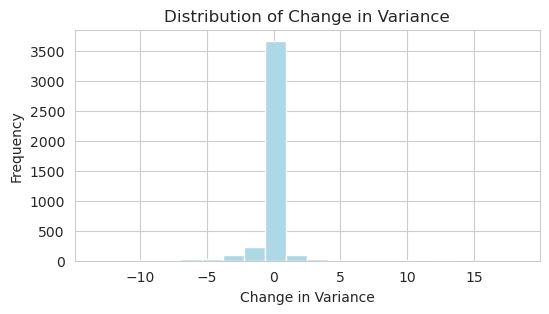

In [ ]:
compare_variance_and_plot(precise1k.X, PRECISE_1K_X_basal)

In [ ]:
def plot_gene_variance(accumulated_changes_dict, expression_matrix, gene_name):
    # Check if gene_name is in the index of expression_matrix
    if gene_name not in expression_matrix.index:
        raise ValueError(f"Gene {gene_name} not found in expression matrix")

    # Original variance of the gene
    original_variance = expression_matrix.loc[gene_name].var()

    # Dictionary to store variances
    variances = {'Original': original_variance}

    # Calculate variance after each correction
    for regulator, df in accumulated_changes_dict.items():
        # Apply correction
        corrected_matrix = expression_matrix + df

        # Check if gene_name is in the index of corrected_matrix
        if gene_name not in corrected_matrix.index:
            raise ValueError(f"Gene {gene_name} not found in corrected matrix for {regulator}")

        # Calculate variance
        variances[regulator] = corrected_matrix.loc[gene_name].var()

    # Find the minimum variance
    min_variance_regulator = min(variances, key=variances.get)

    # Assign colors: red for original, blue for others, salmon for the minimum
    colors = ['salmon' if regulator == min_variance_regulator else 'lightblue' for regulator in variances.keys()]
    if 'Original' != min_variance_regulator:
        colors[0] = 'salmon'  # Set original to red if it's not the minimum

    # Plotting
    plt.figure(figsize=(14, 2.5))
    plt.gcf().set_dpi(300)
    plt.bar(variances.keys(), variances.values(), color=colors)
    plt.xlabel('Corrected Regulator')
    plt.ylabel('Variance')
    plt.title(f'Variance of Corrected {gene_name} Expression')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Examples of the corrected gene expression

#### b2980 - glcC

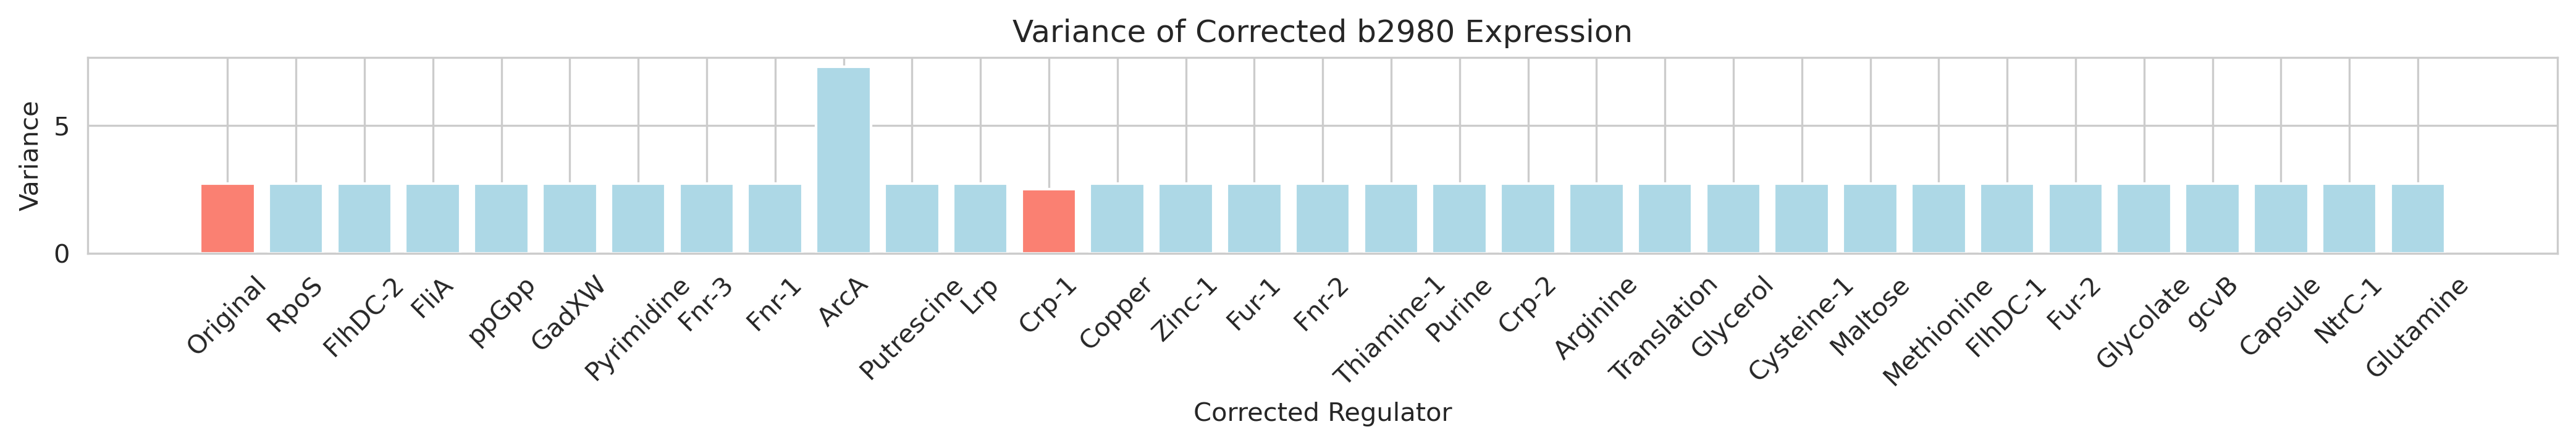

b2980 - Original Expression Values


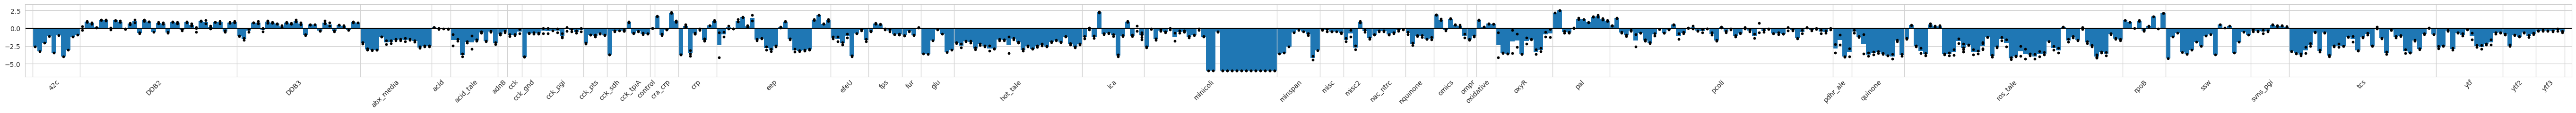

b2980 - Adjusted Expression Values


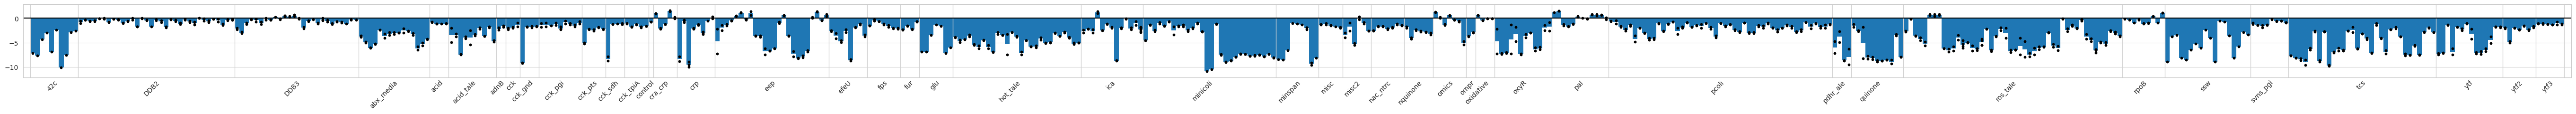

In [ ]:
gene_cur = 'b2980'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

#### b0593 - entC

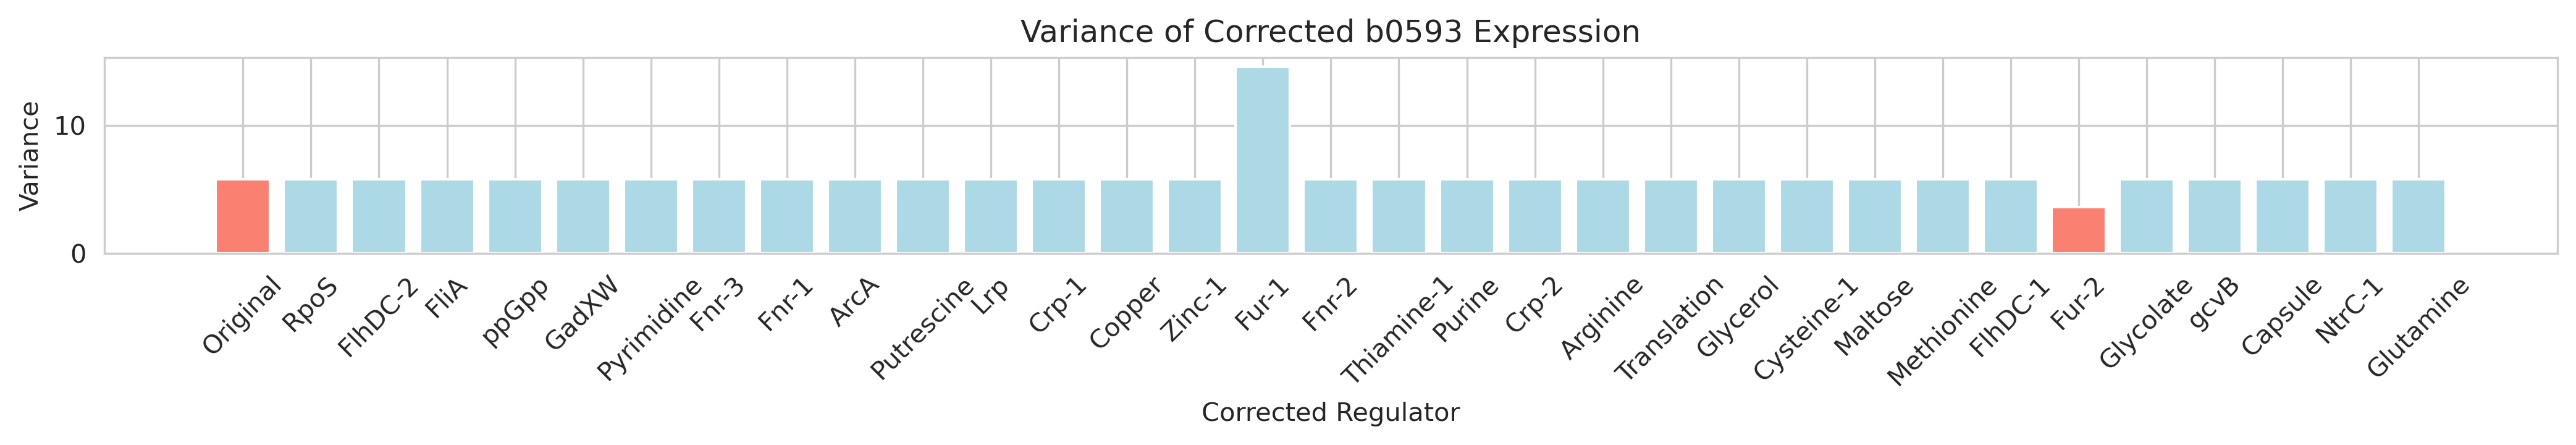

b0593 - Original Expression Values


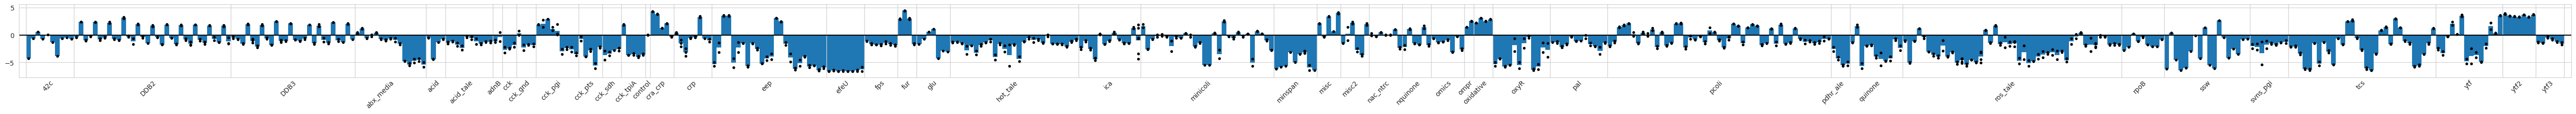

b0593 - Adjusted Expression Values


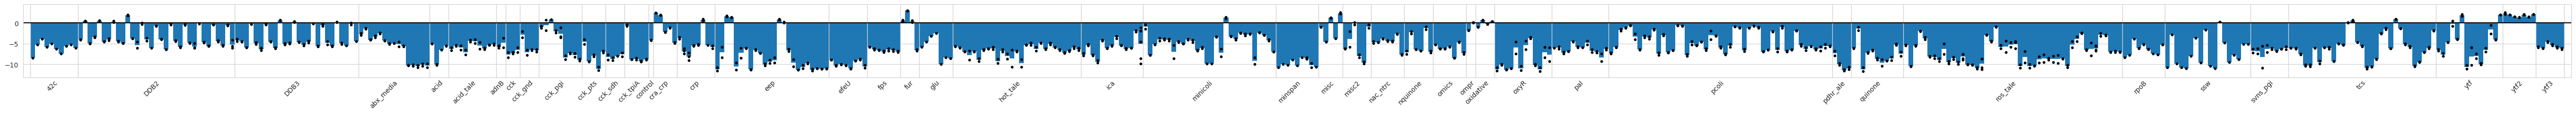

In [ ]:
gene_cur = 'b0593'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

#### b1922 - fliA

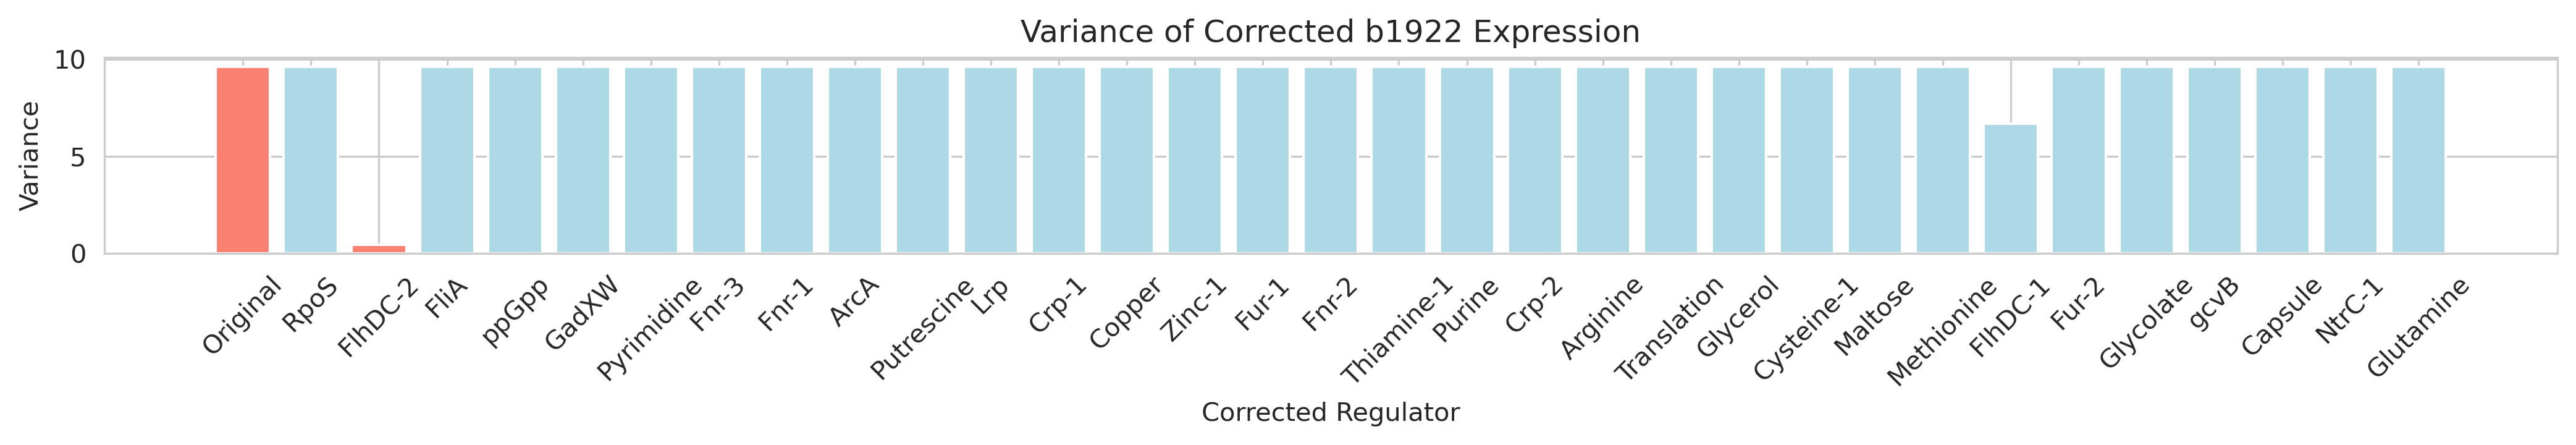

b1922 - Original Expression Values


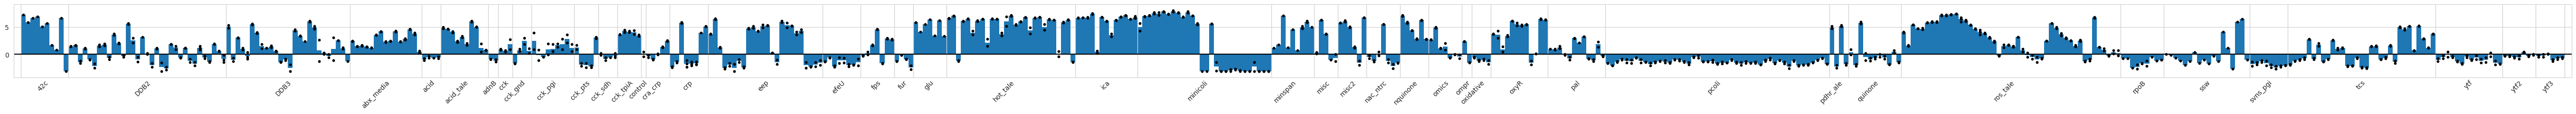

b1922 - Adjusted Expression Values


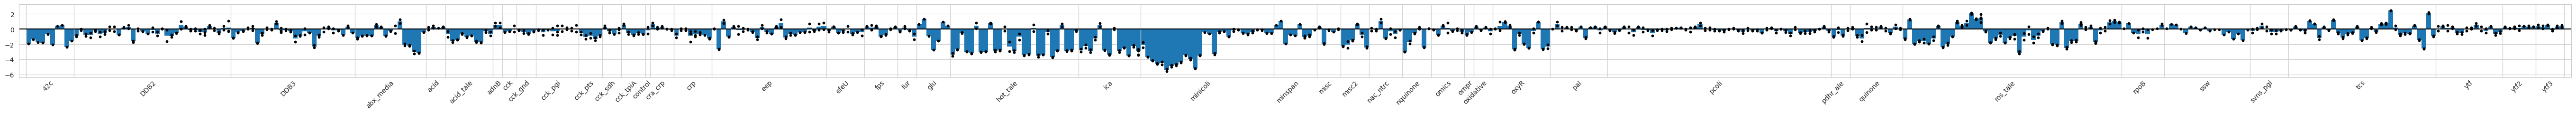

In [ ]:
gene_cur = 'b1922'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

#### b0198 - metI

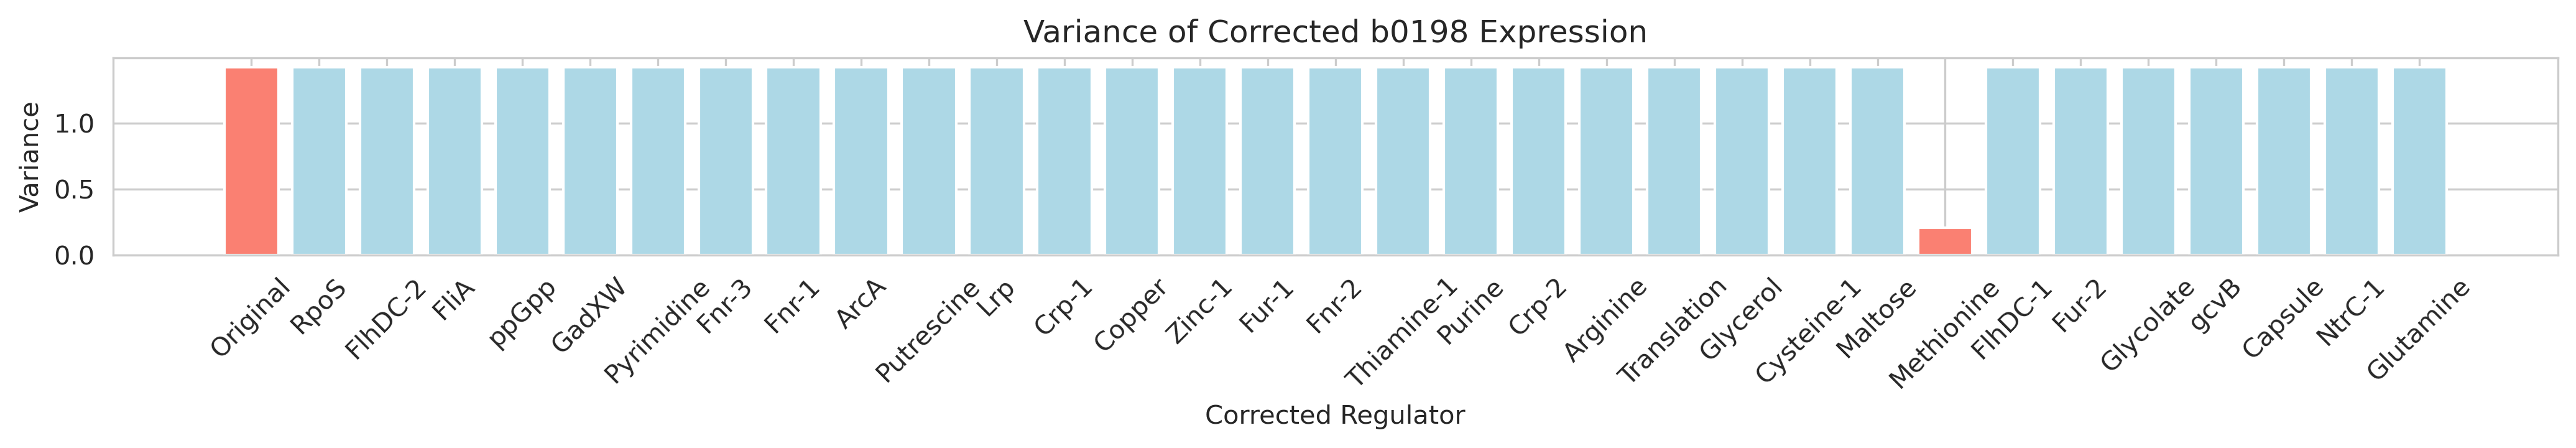

b0198 - Original Expression Values


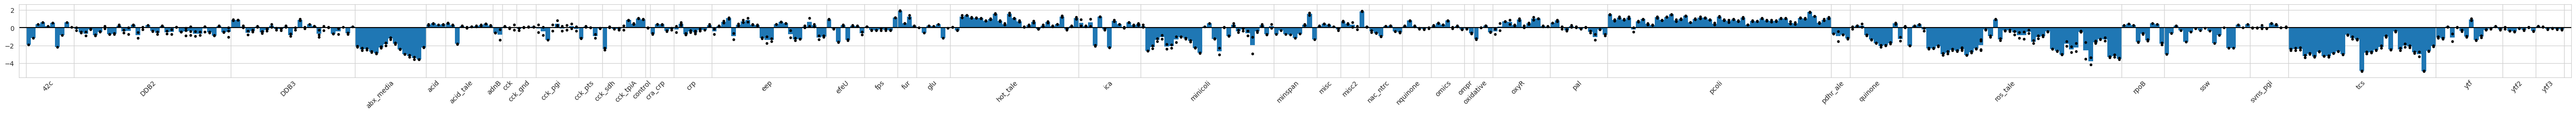

b0198 - Adjusted Expression Values


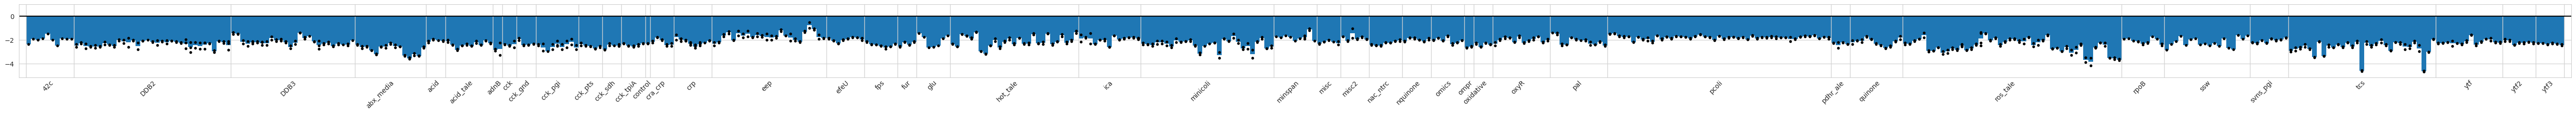

In [ ]:
gene_cur = 'b0198'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

#### b2818 - argA

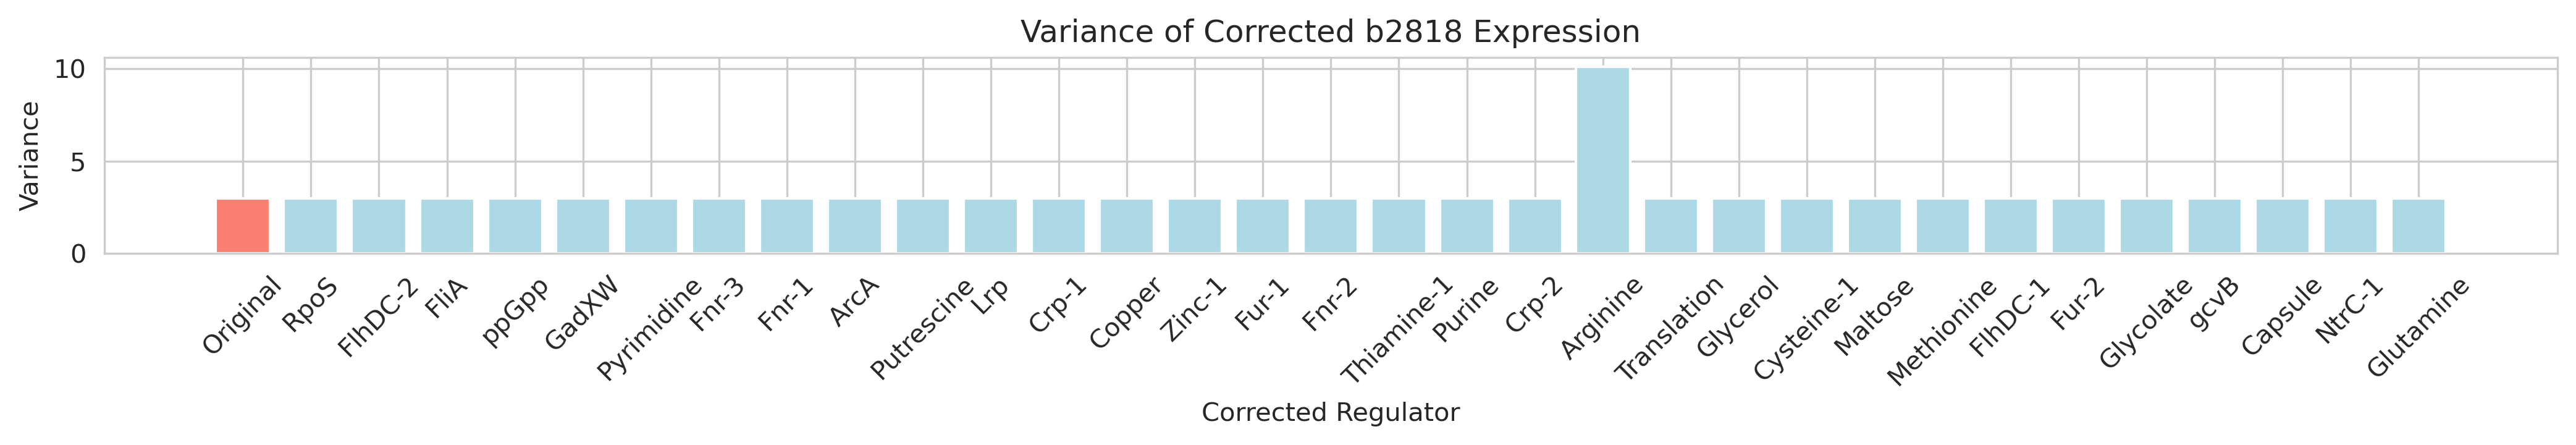

b2818 - Original Expression Values


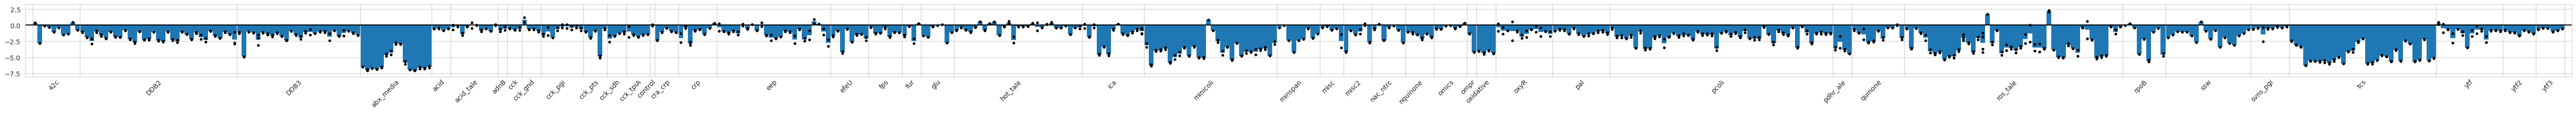

b2818 - Adjusted Expression Values


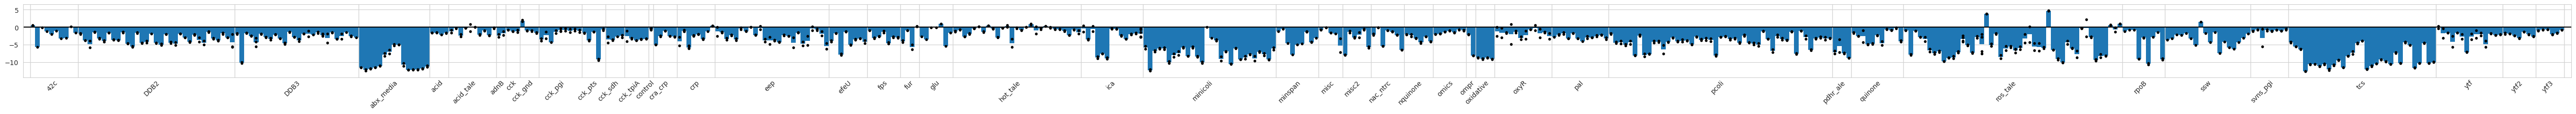

In [ ]:
gene_cur = 'b2818'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

### Genes that have increased variance after correction

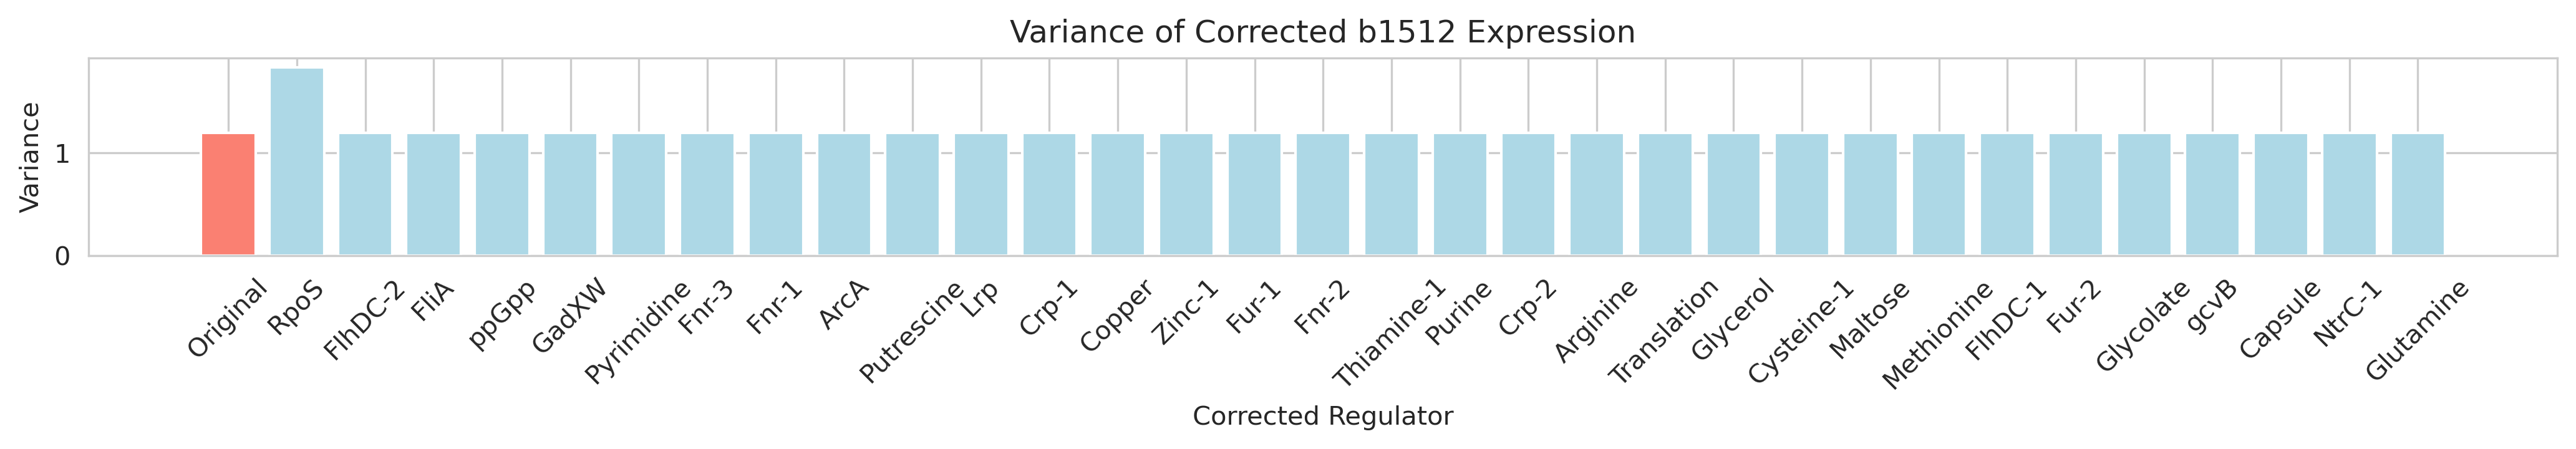

b1512 - Original Expression Values


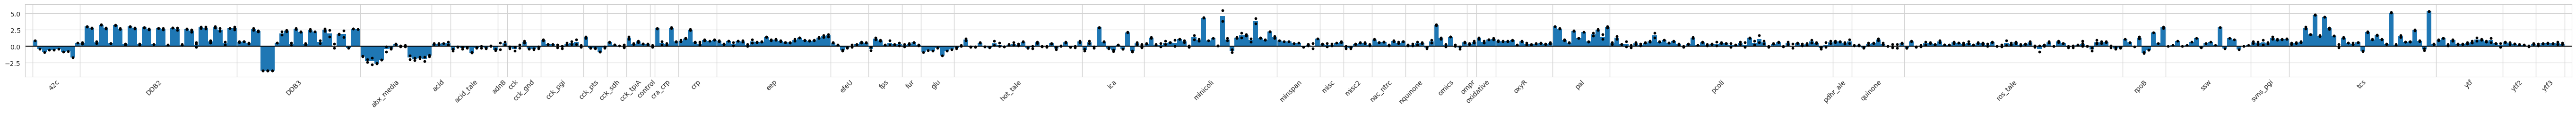

b1512 - Adjusted Expression Values


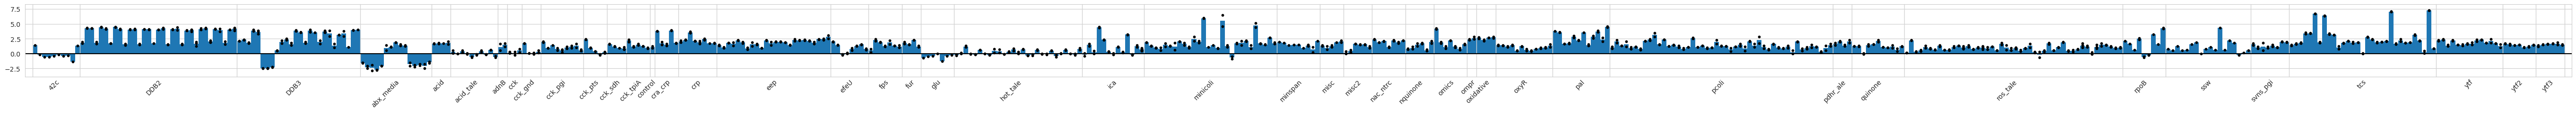

In [ ]:
gene_cur = 'b1512'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

iMDB screenshot for b1512 - negative weight in M

<img src="attachment:9e63c372-0260-4141-a9ea-090094cd848c.png" width="1300">


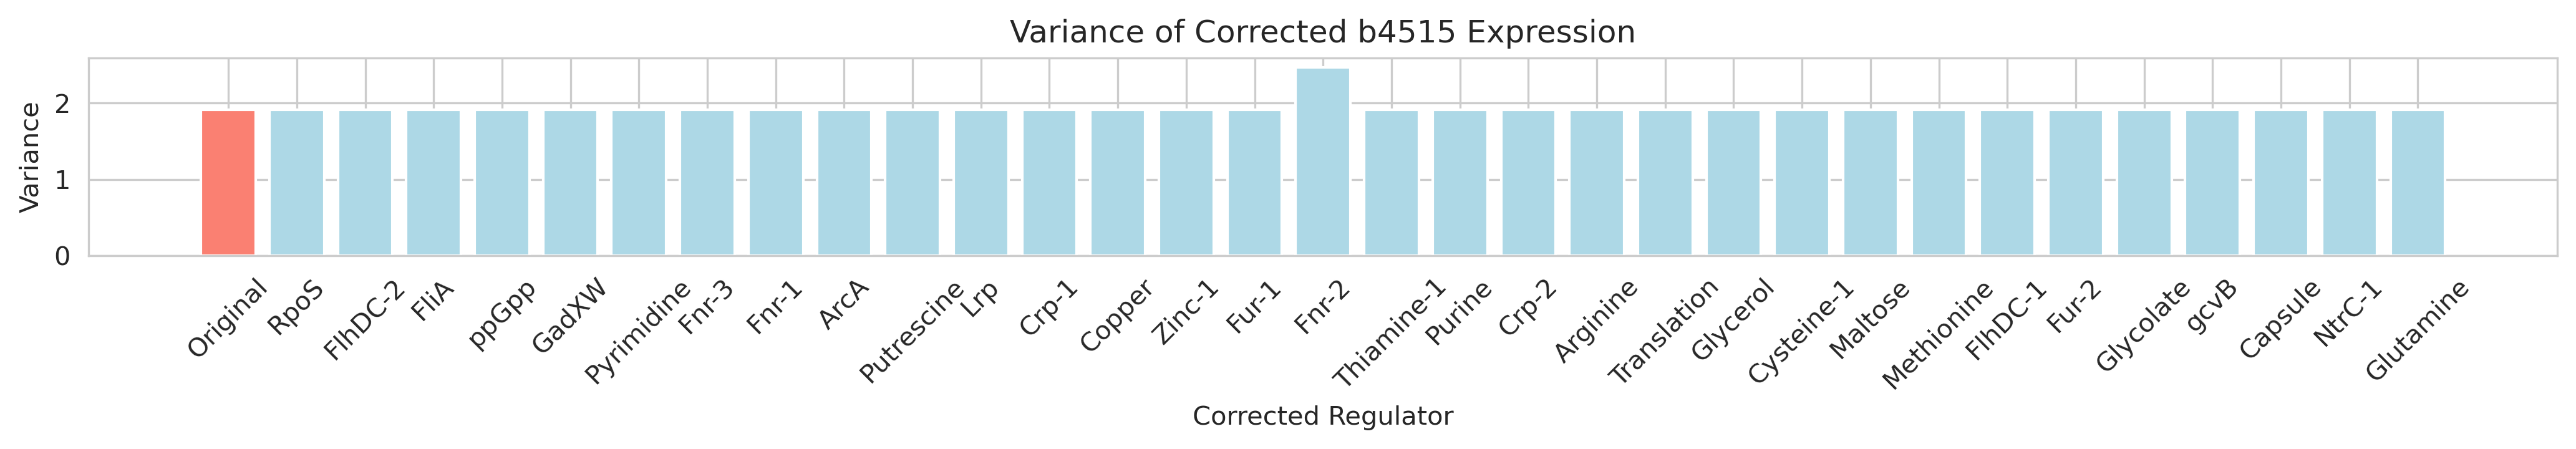

b4515 - Original Expression Values


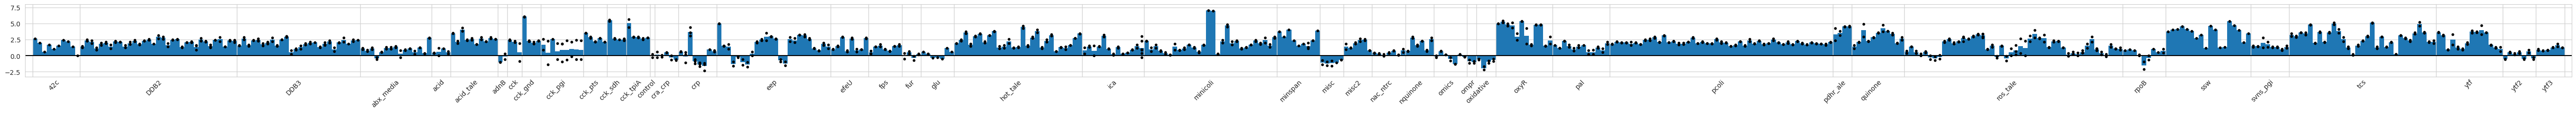

b4515 - Adjusted Expression Values


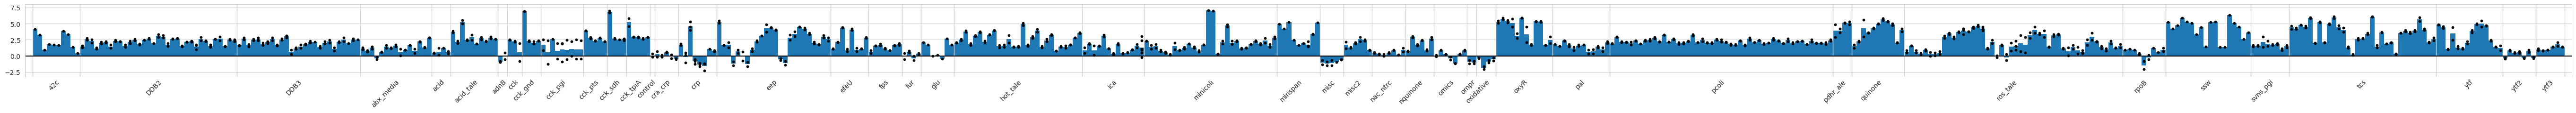

In [ ]:
gene_cur = 'b4515'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

iMDB screenshot for b4515 - negative weight in M

<img src="attachment:a56f54f5-c3f9-4063-9e9a-b821d4c01a78.png" width="1300">


### Check on genes to make sure their expression ranges are diminished post correction even if the activity doesnt look diminished

#### Crp

In [ ]:
# Function to get genes regulated by a specific regulator
def get_regulated_genes(df, regulator_name):
    if regulator_name in df.columns:
        regulated_genes = df.index[df[regulator_name] == 1].tolist()
        return regulated_genes
    else:
        return "Regulator name not found in DataFrame."

In [ ]:
Crp_genes = get_regulated_genes(TF_Gene_binary_matrix_p1k, 'Crp')

In [ ]:
# Preparing the data for plotting
def get_top_changed_genes(df1, df2, regulated_genes, num_genes=25):
    change = (df1.loc[regulated_genes].mean(axis=1) - df2.loc[regulated_genes].mean(axis=1)).abs()
    top_genes = change.nlargest(num_genes).index
    return top_genes
    
def prepare_data_for_plotting(df1, df2, top_genes):
    df1_melted = df1.loc[top_genes].reset_index().melt(id_vars='index', var_name='Condition', value_name='Expression')
    df1_melted['Dataset'] = 'PRECISE-1K'
    df2_melted = df2.loc[top_genes].reset_index().melt(id_vars='index', var_name='Condition', value_name='Expression')
    df2_melted['Dataset'] = 'Basal X'
    combined_df = pd.concat([df1_melted, df2_melted])
    combined_df = combined_df.rename(columns={'index': 'Gene'})
    return combined_df

# Plotting function
def plot_expression(combined_df, top_genes):
    plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
    plt.gcf().set_dpi(300)
    sns.boxplot(x='Gene', y='Expression', hue='Dataset', data=combined_df, palette=["lightblue", "salmon"])
    plt.title('Crp Genes - Compare Expression of Original PRECISE-1K X and Basal X')
    plt.show()

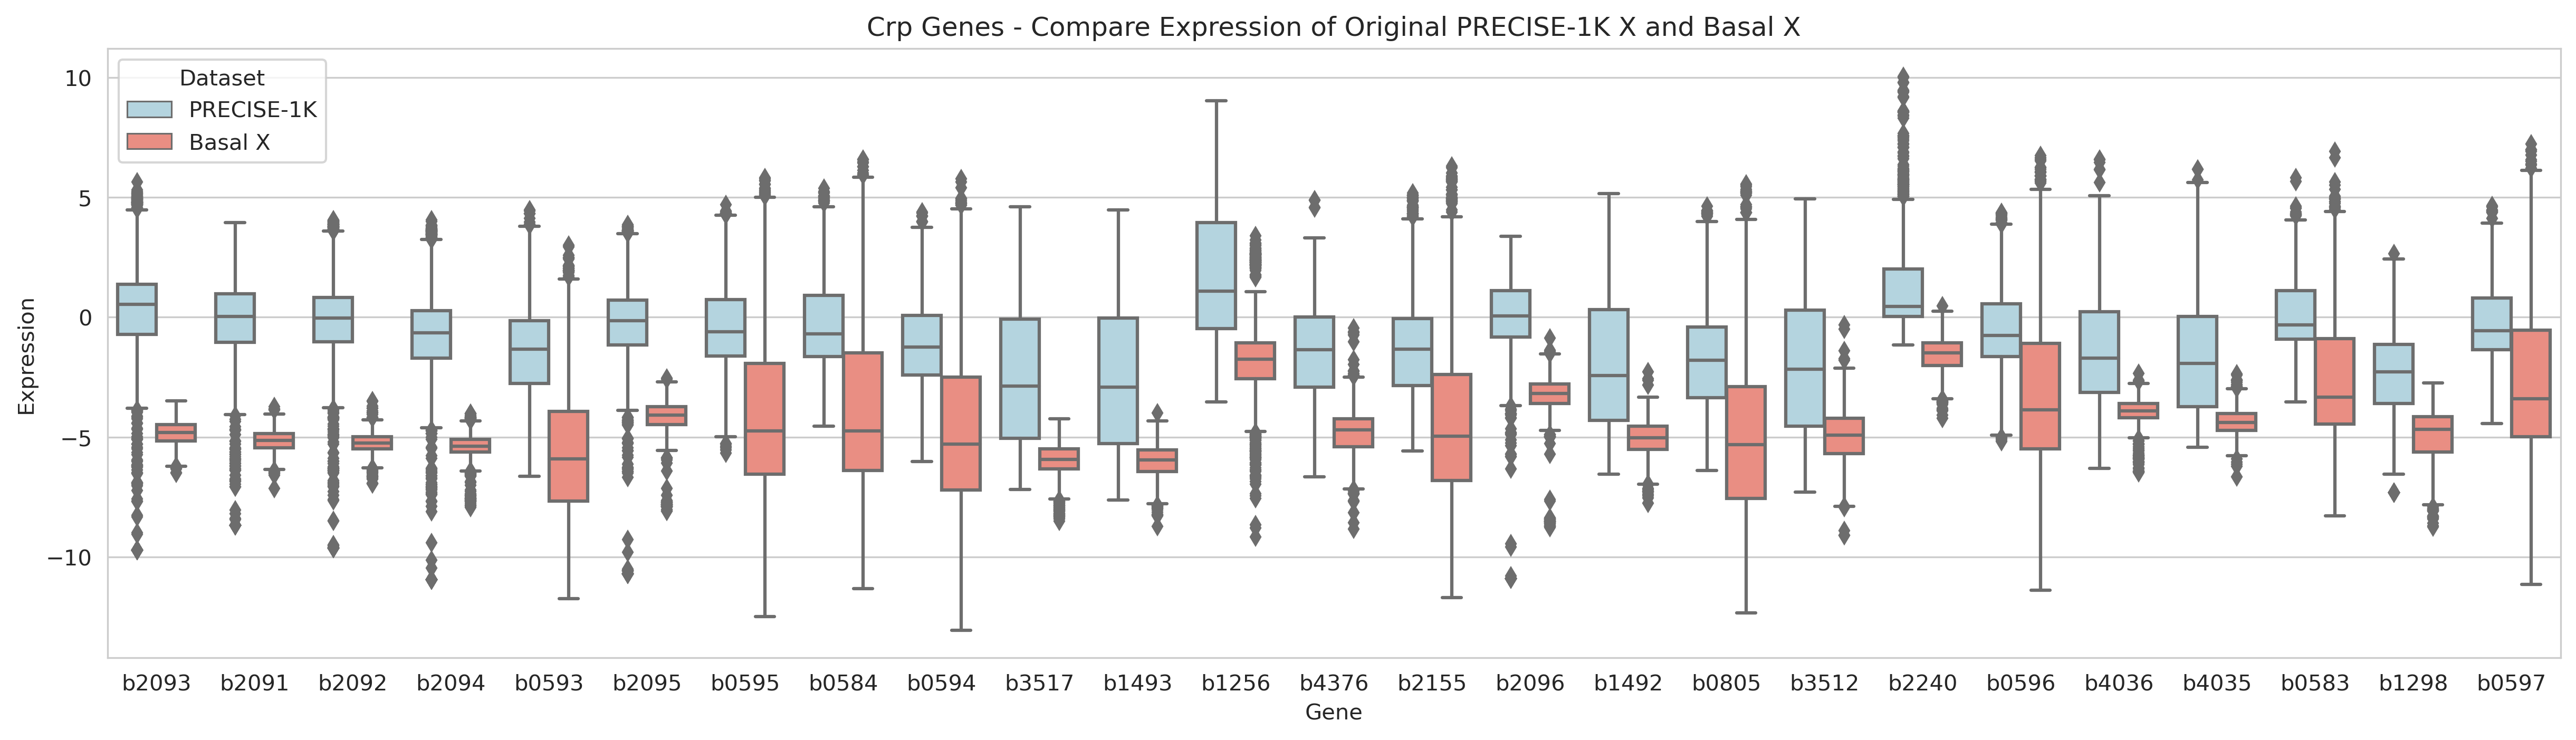

In [ ]:
top_genes = get_top_changed_genes(precise1k.X, PRECISE_1K_X_basal, Crp_genes)
combined_df = prepare_data_for_plotting(precise1k.X, PRECISE_1K_X_basal, top_genes)
plot_expression(combined_df, top_genes)

#### Lrp

In [ ]:
Lrp_genes = get_regulated_genes(Binarized_renamed_gene_presence_matrix, 'Lrp')

In [ ]:
# Preparing the data for plotting
def get_top_changed_genes(df1, df2, regulated_genes, num_genes=15):
    change = (df1.loc[regulated_genes].mean(axis=1) - df2.loc[regulated_genes].mean(axis=1)).abs()
    top_genes = change.nlargest(num_genes).index
    return top_genes
    
def prepare_data_for_plotting(df1, df2, top_genes):
    df1_melted = df1.loc[top_genes].reset_index().melt(id_vars='index', var_name='Condition', value_name='Expression')
    df1_melted['Dataset'] = 'PRECISE-1K'
    df2_melted = df2.loc[top_genes].reset_index().melt(id_vars='index', var_name='Condition', value_name='Expression')
    df2_melted['Dataset'] = 'Basal X'
    combined_df = pd.concat([df1_melted, df2_melted])
    combined_df = combined_df.rename(columns={'index': 'Gene'})
    return combined_df

# Plotting function
def plot_expression(combined_df, top_genes):
    plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
    plt.gcf().set_dpi(300)
    sns.boxplot(x='Gene', y='Expression', hue='Dataset', data=combined_df, palette=["lightblue", "salmon"])
    plt.title('Lrp Genes - Compare Expression of Original PRECISE-1K X and Basal X')
    plt.show()

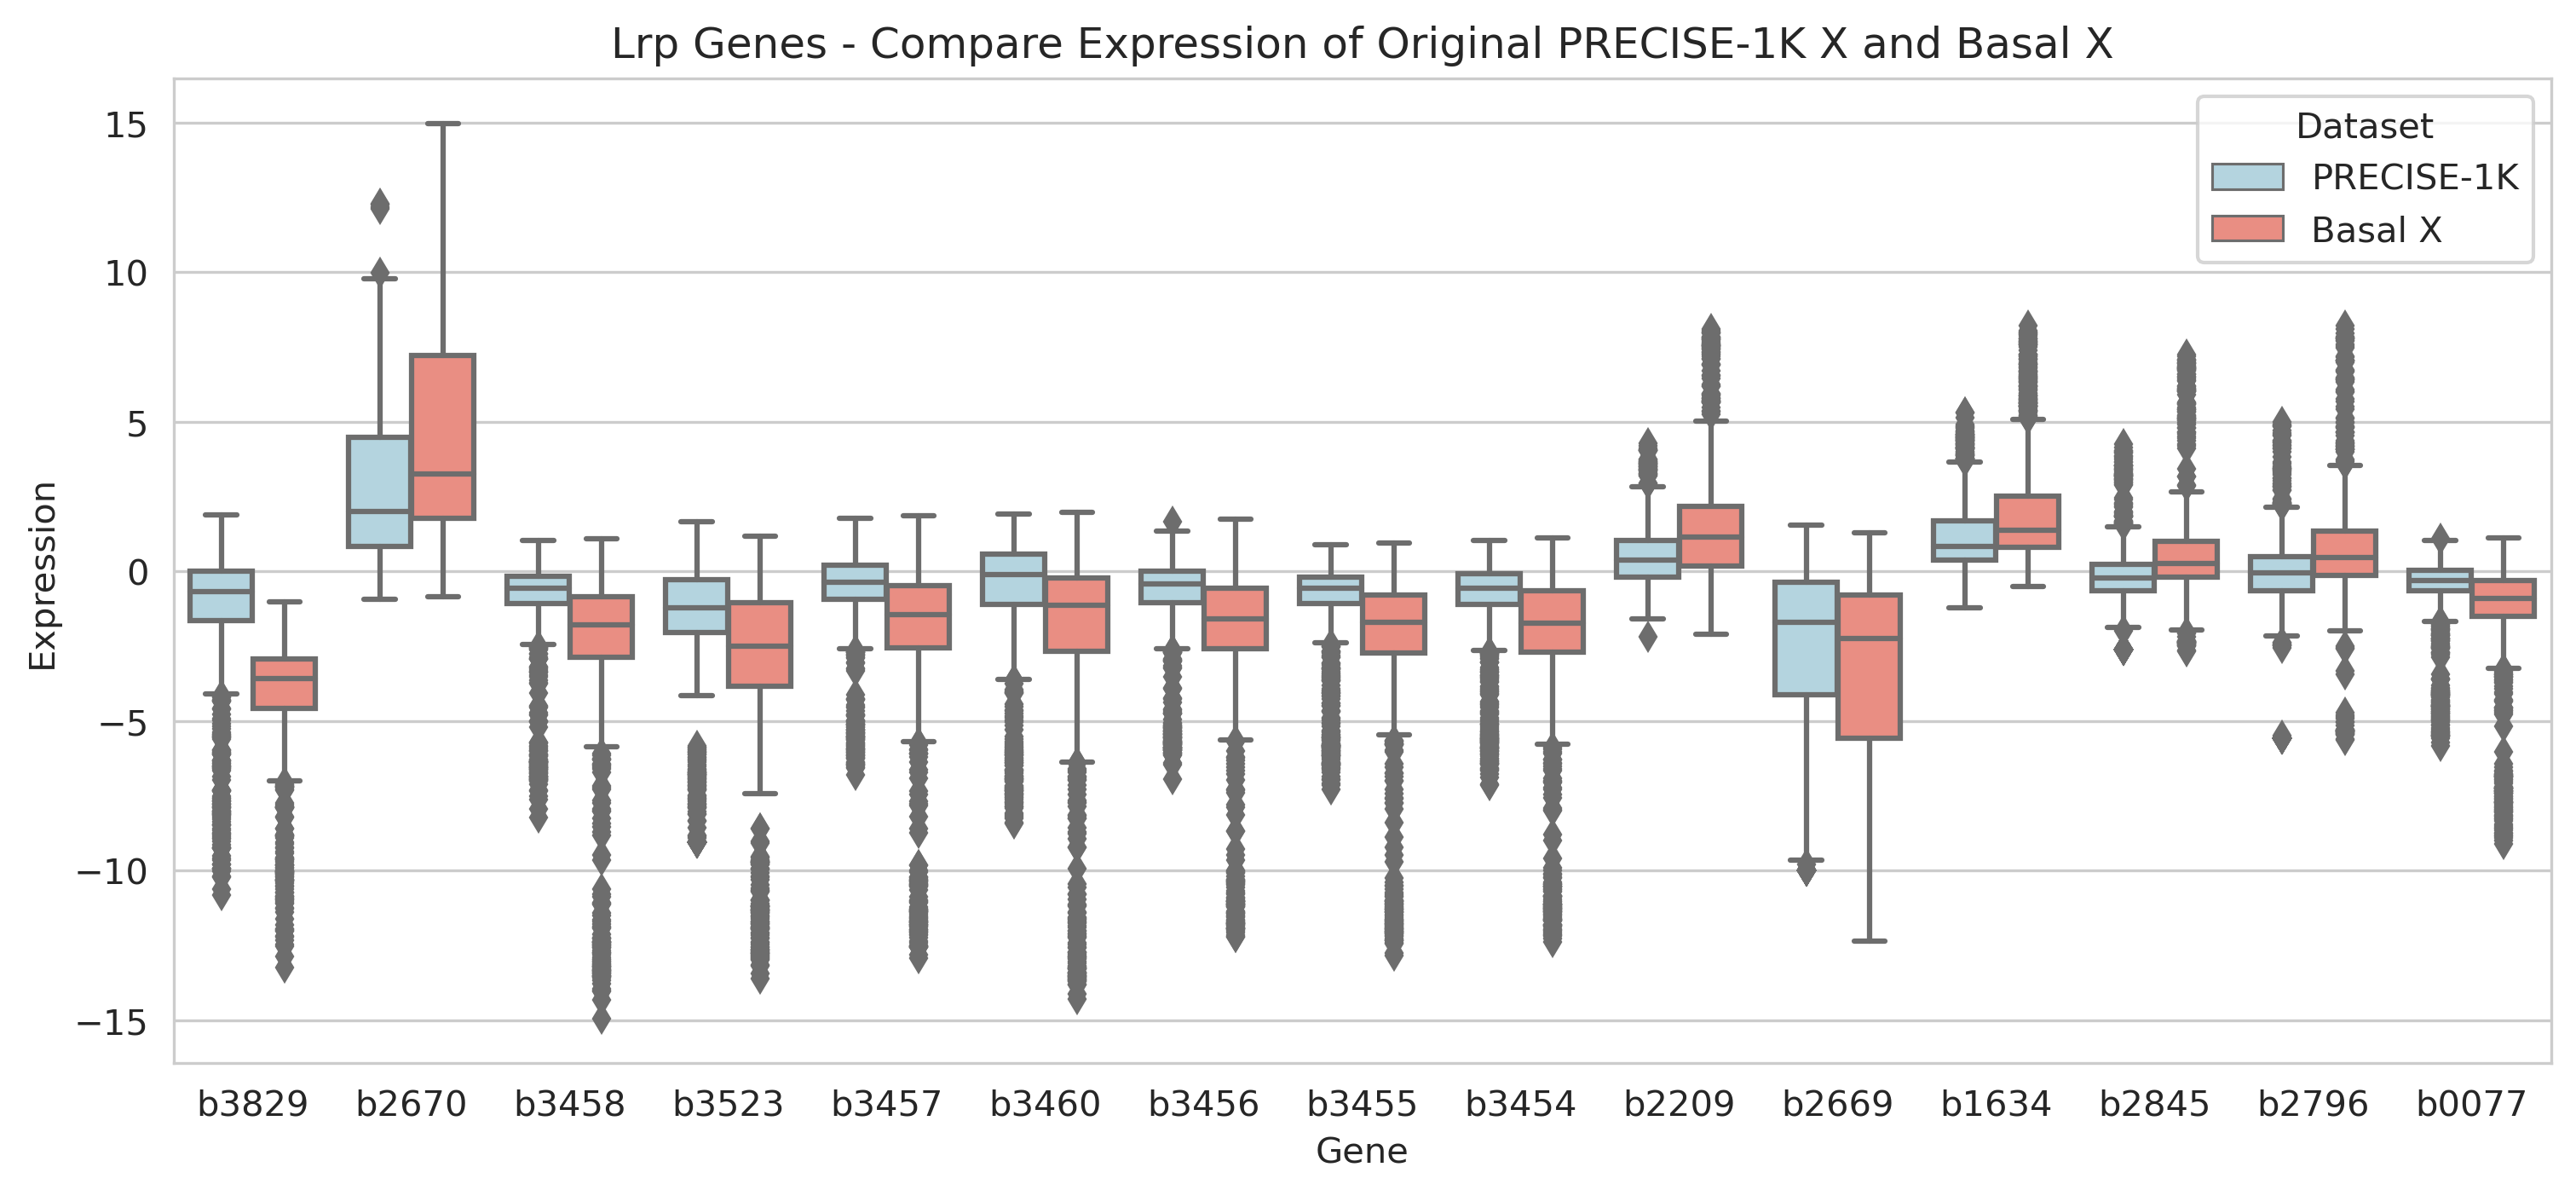

In [ ]:
top_genes = get_top_changed_genes(precise1k.X, PRECISE_1K_X_basal, Lrp_genes)
combined_df = prepare_data_for_plotting(precise1k.X, PRECISE_1K_X_basal, top_genes)
plot_expression(combined_df, top_genes)

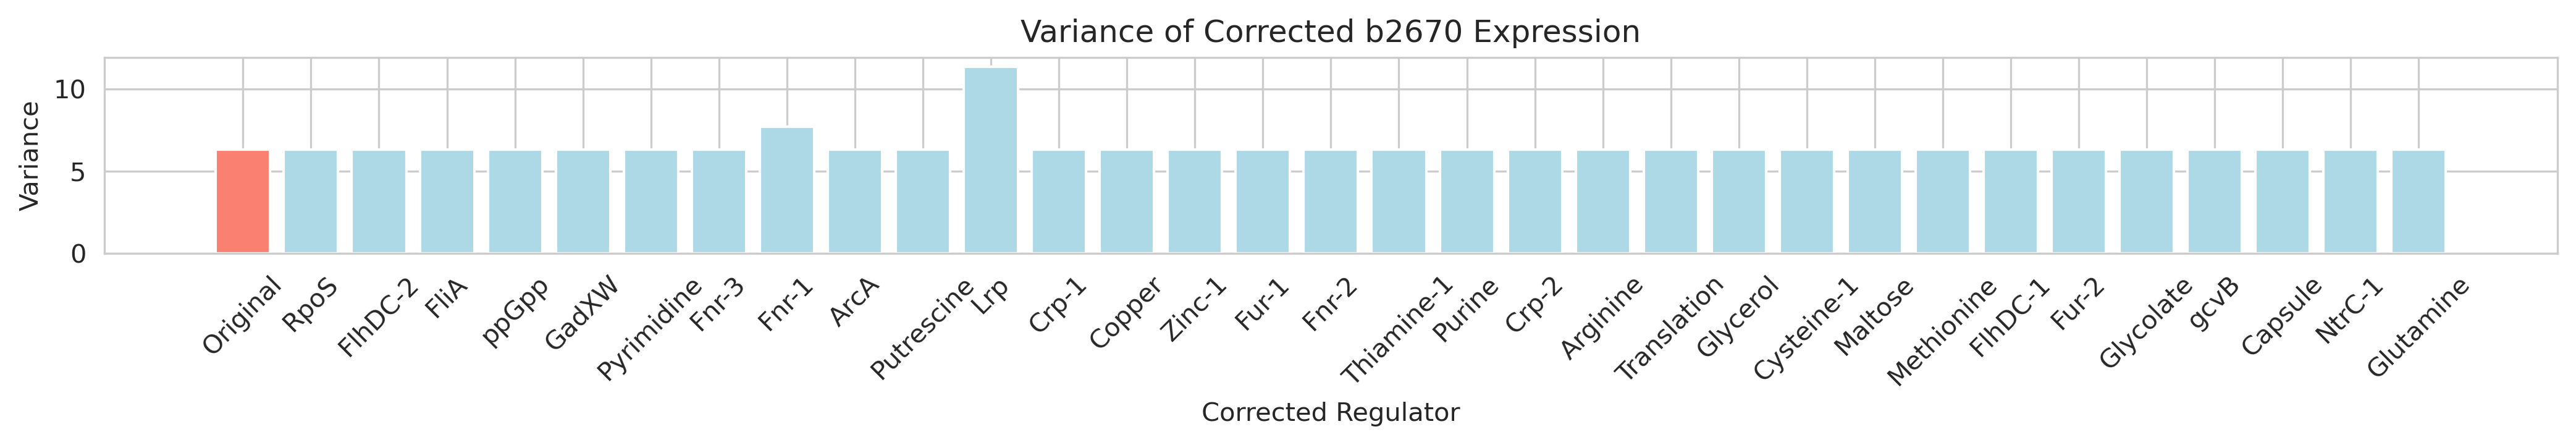

b2670 - Original Expression Values


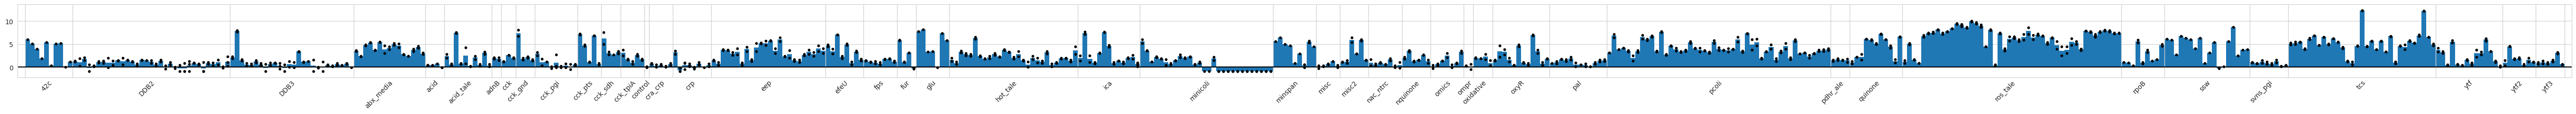

b2670 - Adjusted Expression Values


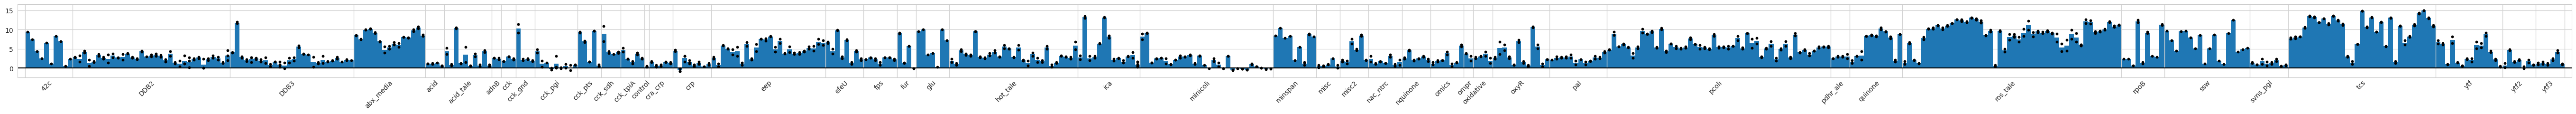

In [ ]:
gene_cur = 'b2670'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

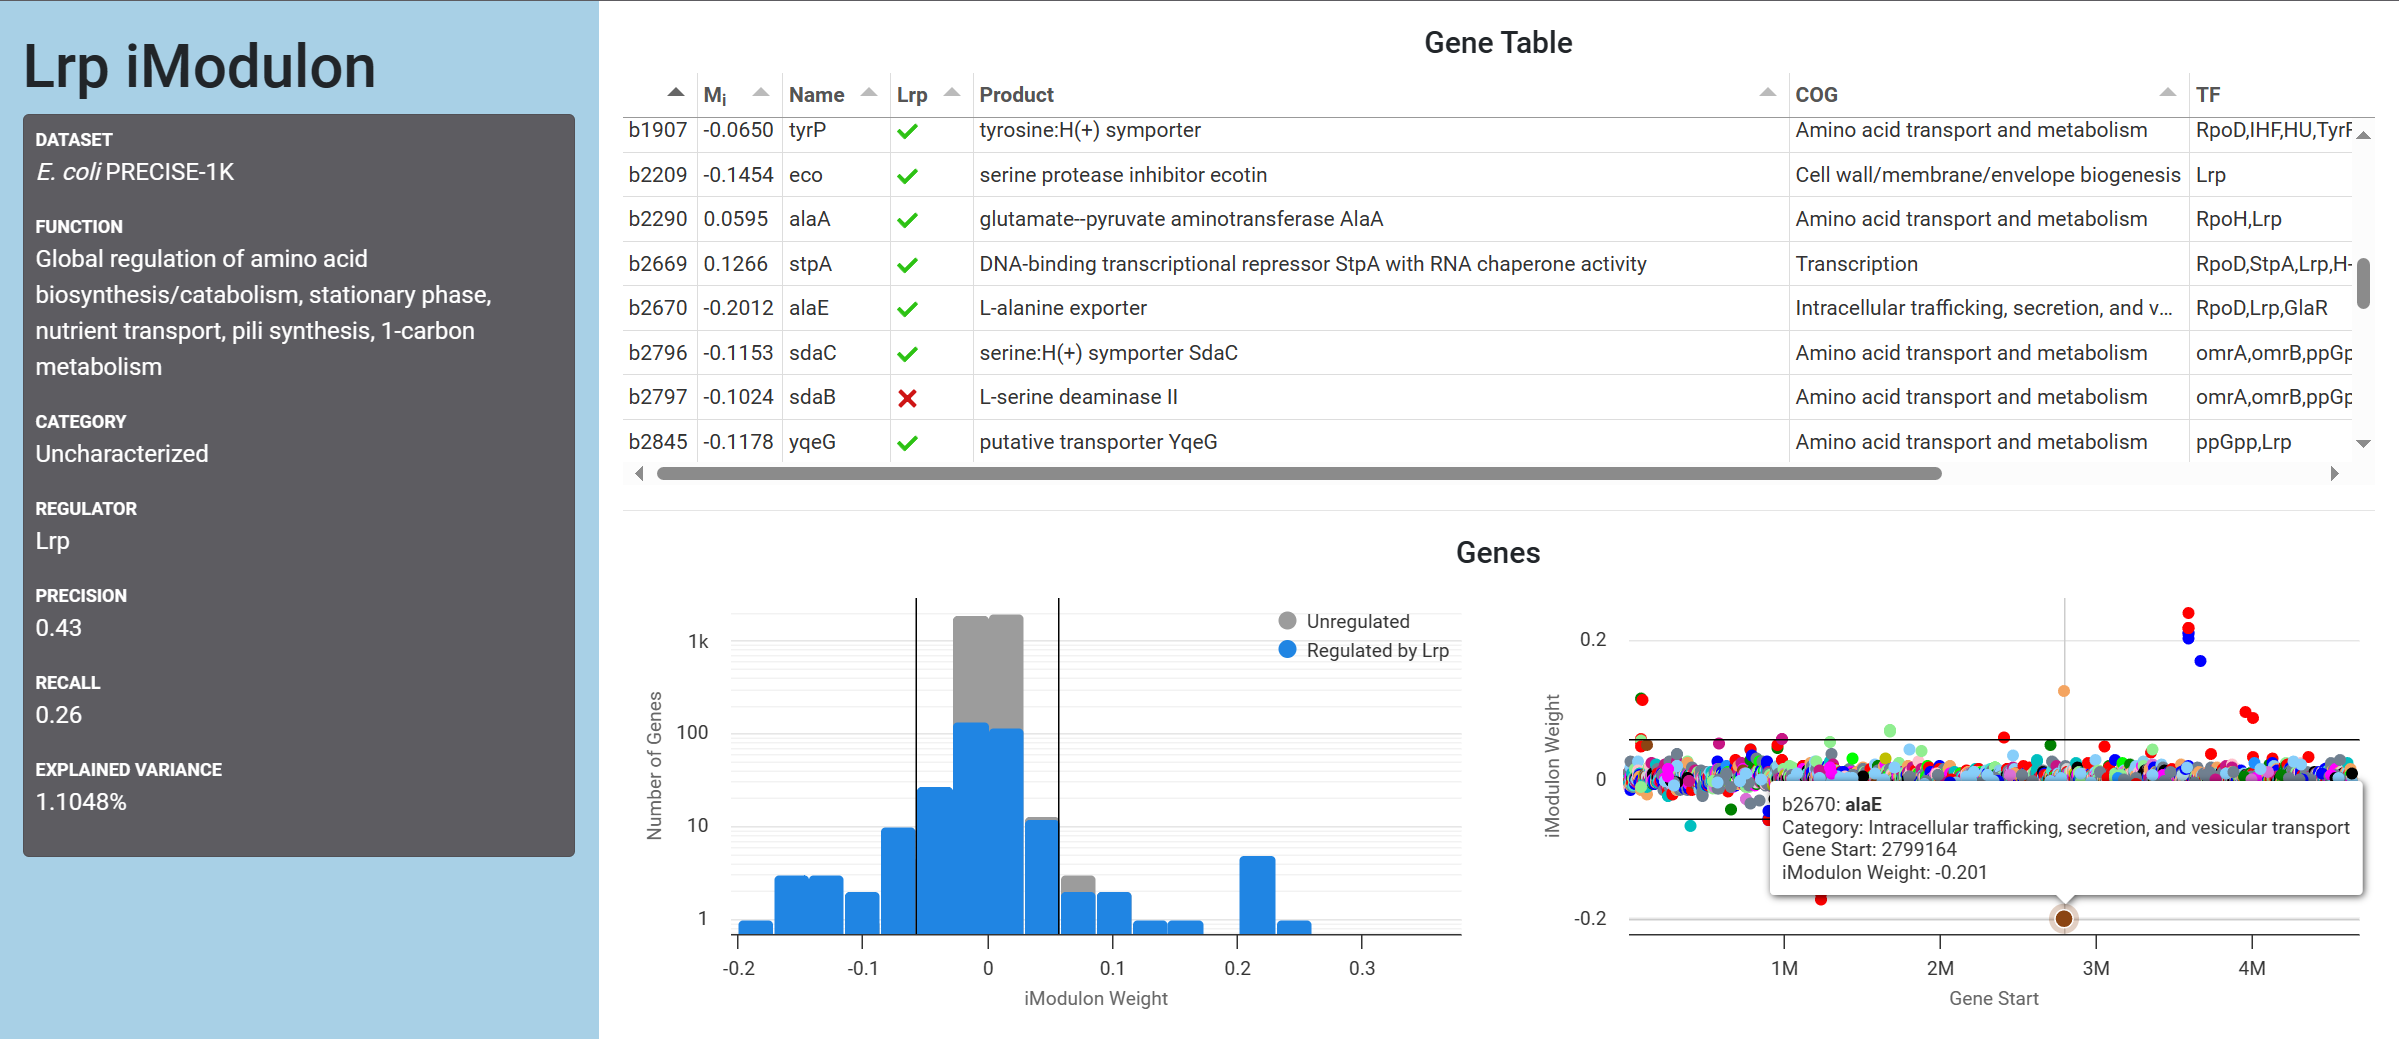

#### ArgR

In [ ]:
ArgR_genes = get_regulated_genes(Binarized_renamed_gene_presence_matrix, 'Arginine')

In [ ]:
# Preparing the data for plotting
def get_top_changed_genes(df1, df2, regulated_genes, num_genes=15):
    change = (df1.loc[regulated_genes].mean(axis=1) - df2.loc[regulated_genes].mean(axis=1)).abs()
    top_genes = change.nlargest(num_genes).index
    return top_genes
    
def prepare_data_for_plotting(df1, df2, top_genes):
    df1_melted = df1.loc[top_genes].reset_index().melt(id_vars='index', var_name='Condition', value_name='Expression')
    df1_melted['Dataset'] = 'PRECISE-1K'
    df2_melted = df2.loc[top_genes].reset_index().melt(id_vars='index', var_name='Condition', value_name='Expression')
    df2_melted['Dataset'] = 'Basal X'
    combined_df = pd.concat([df1_melted, df2_melted])
    combined_df = combined_df.rename(columns={'index': 'Gene'})
    return combined_df

# Plotting function
def plot_expression(combined_df, top_genes):
    plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
    plt.gcf().set_dpi(300)
    sns.boxplot(x='Gene', y='Expression', hue='Dataset', data=combined_df, palette=["lightblue", "salmon"])
    plt.title('ArgR Genes - Compare Expression of Original PRECISE-1K X and Basal X')
    plt.show()

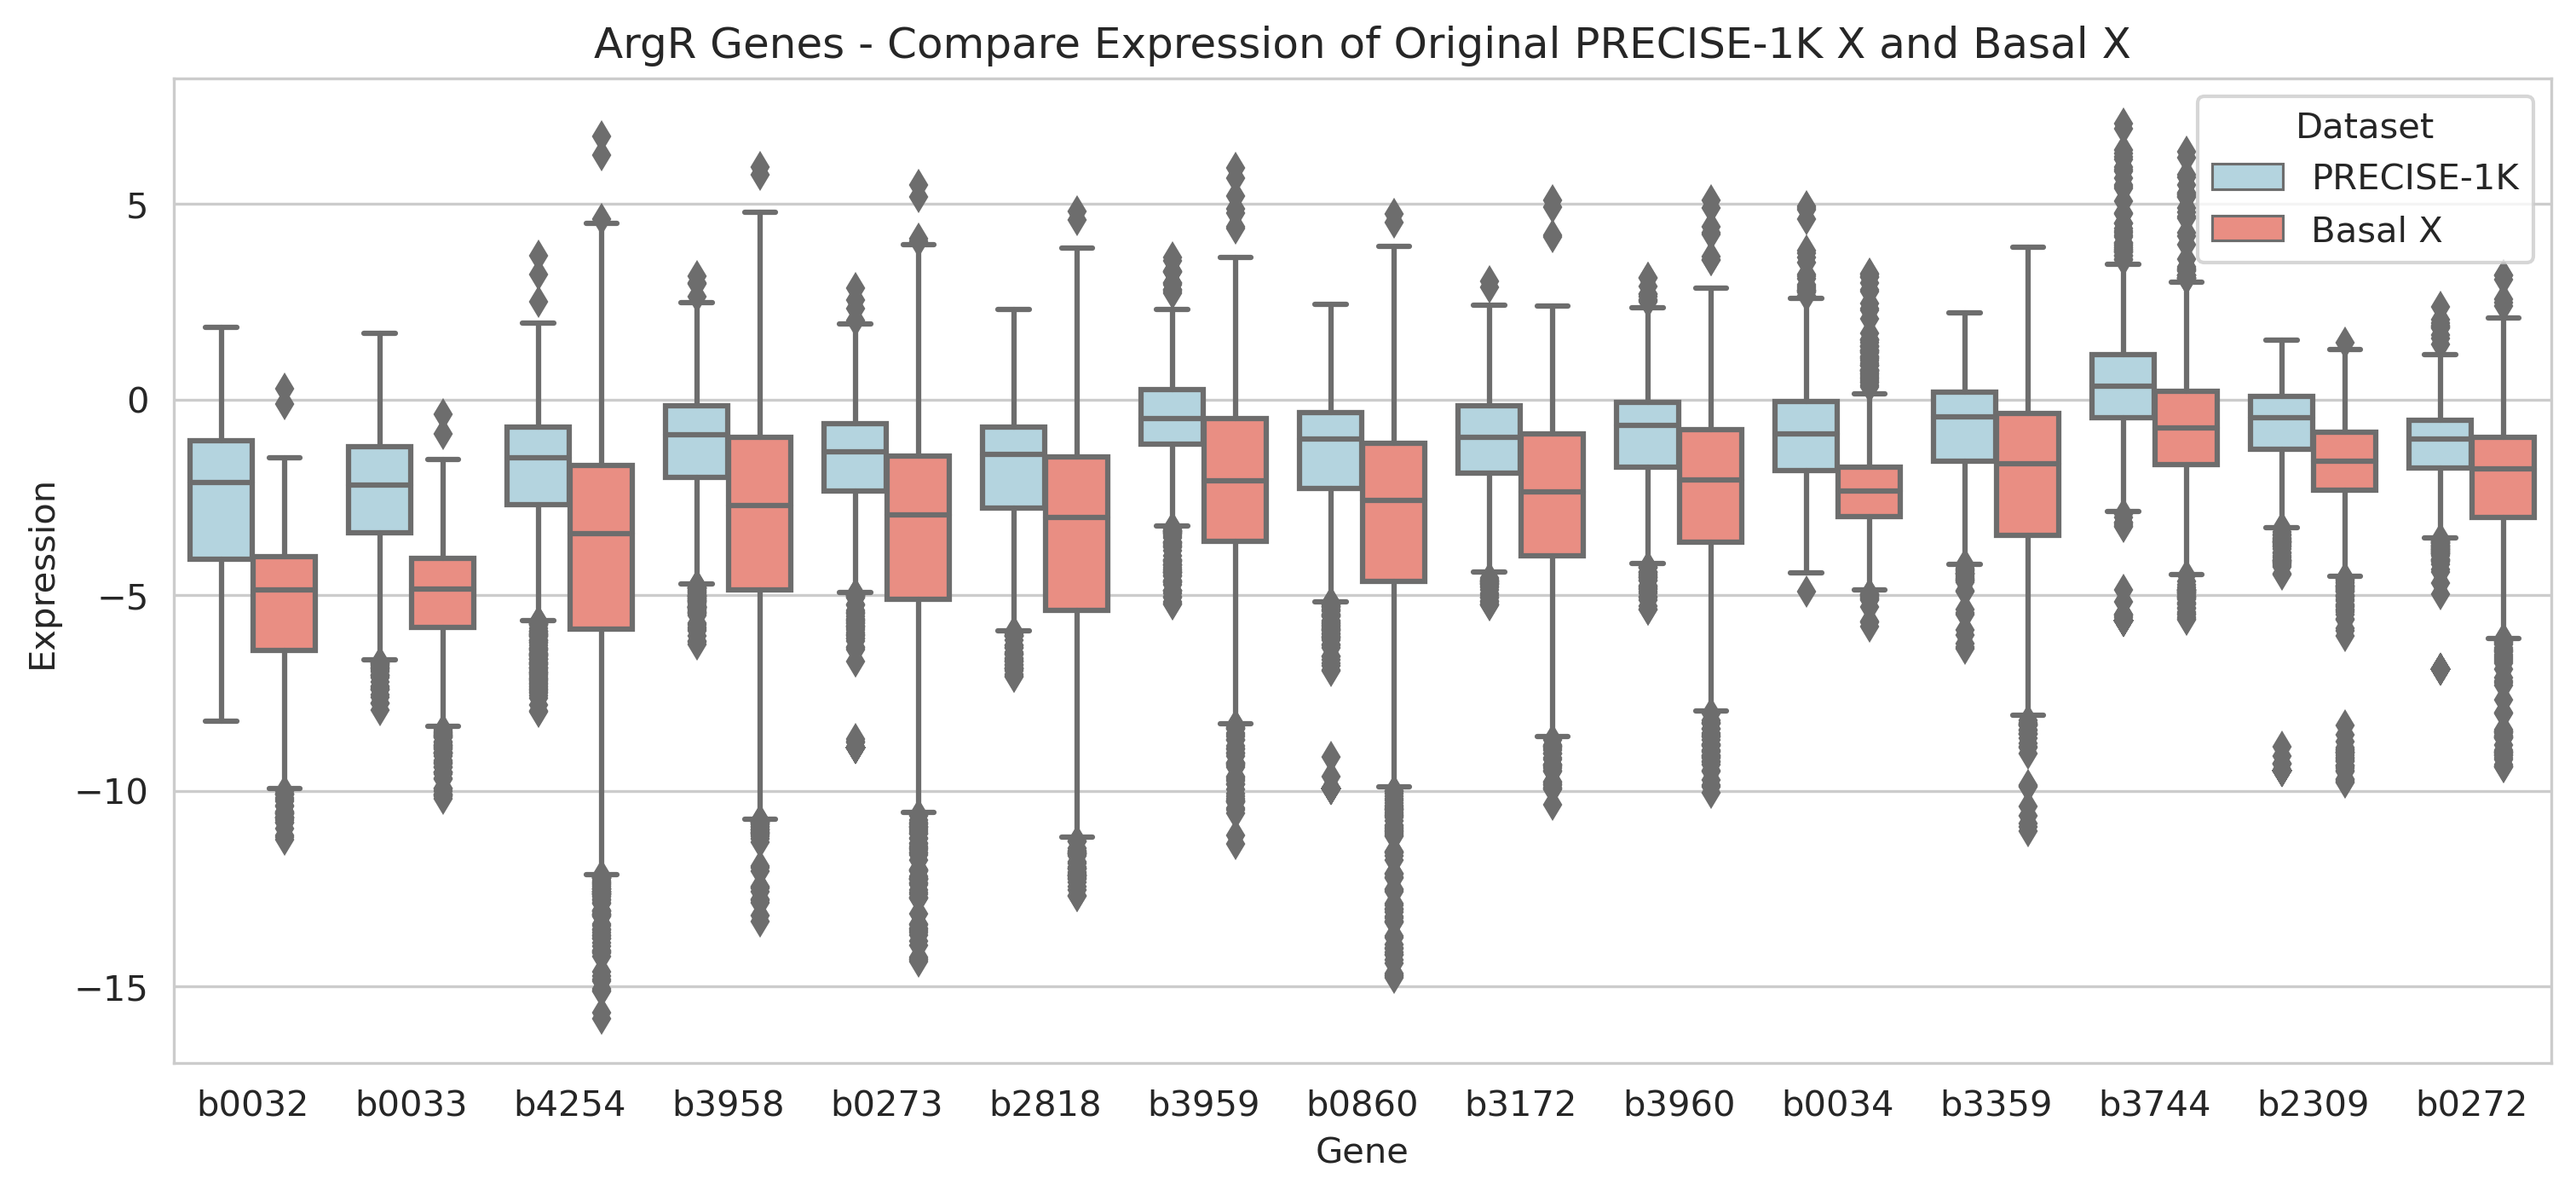

In [ ]:
top_genes = get_top_changed_genes(precise1k.X, PRECISE_1K_X_basal, ArgR_genes)
combined_df = prepare_data_for_plotting(precise1k.X, PRECISE_1K_X_basal, top_genes)
plot_expression(combined_df, top_genes)

### See which genes on glucose reference change their expression the most from these corrections (log scale)

In [ ]:
# Function to extract two columns from a DataFrame
def extract_columns(df, column1, column2):
    if column1 in df.columns and column2 in df.columns:
        new_df = df[[column1, column2]]
        return new_df
    else:
        return "One or both column names not found in the DataFrame."

In [ ]:
Glucose_PRECISE_1K = precise1k.X[['p1k_00002']]

In [ ]:
Glucose_Basal_X = PRECISE_1K_X_basal[['p1k_00002']]

In [ ]:
# Function to find top 20 genes with the most change in log scale
def top_changed_genes(df1, df2, top_n=20):
    # Ensure the two dataframes have the same genes
    common_genes = df1.index.intersection(df2.index)
    df1_common = df1.loc[common_genes]
    df2_common = df2.loc[common_genes]

    # Calculate the difference in log scale
    log_diff = (df1_common - df2_common).abs()

    # Find the top N genes with the most change
    top_genes = log_diff.nlargest(top_n, df1.columns[0]).index
    return top_genes

In [ ]:
top_20_genes = top_changed_genes(Glucose_PRECISE_1K, Glucose_Basal_X)
top_20_genes

Index(['b4245', 'b4244', 'b0573', 'b0572', 'b0574', 'b3509', 'b3555', 'b3511',
       'b3510', 'b3517', 'b1493', 'b0897', 'b2672', 'b2093', 'b2091', 'b2092',
       'b0575', 'b3508', 'b1492', 'b1300'],
      dtype='object')

In [ ]:
# Function to plot gene expression comparison
def plot_gene_expression_comparison(gene_set, df1, df2):
    # Filter for the genes of interest
    df1_filtered = df1.loc[gene_set]
    df2_filtered = df2.loc[gene_set]

    # Prepare the data for plotting
    df1_melted = df1_filtered.reset_index().melt(id_vars='index', value_name='Expression')
    df1_melted['Dataset'] = 'PRECISE-1K X'
    df2_melted = df2_filtered.reset_index().melt(id_vars='index', value_name='Expression')
    df2_melted['Dataset'] = 'Basal X'
    combined_df = pd.concat([df1_melted, df2_melted])
    combined_df = combined_df.rename(columns={'index': 'Gene'})

    # Plotting
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Gene', y='Expression', hue='Dataset', data=combined_df, palette=["lightblue", "salmon"])
    plt.title('Top Genes with Significant Expression Changes - Glucose Condition')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

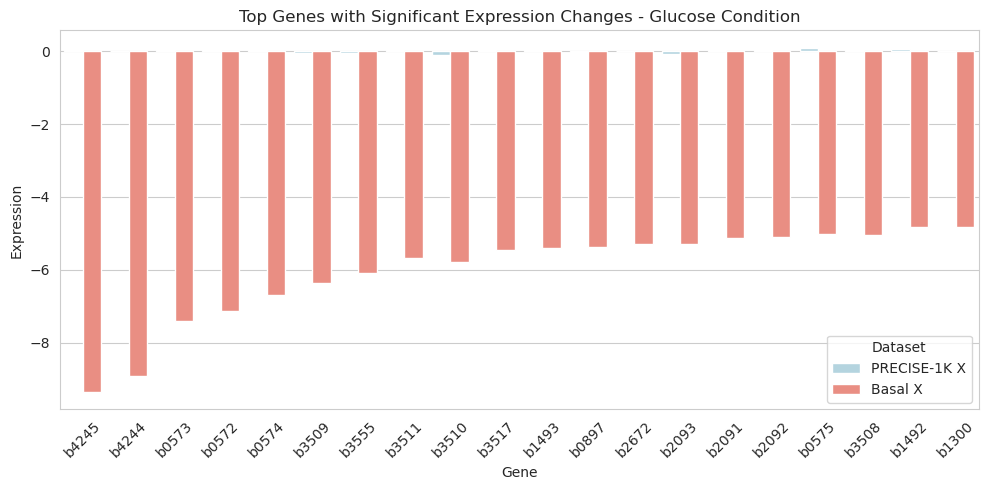

In [ ]:
plot_gene_expression_comparison(top_20_genes, Glucose_PRECISE_1K, Glucose_Basal_X)

#### b4245 - pyrB

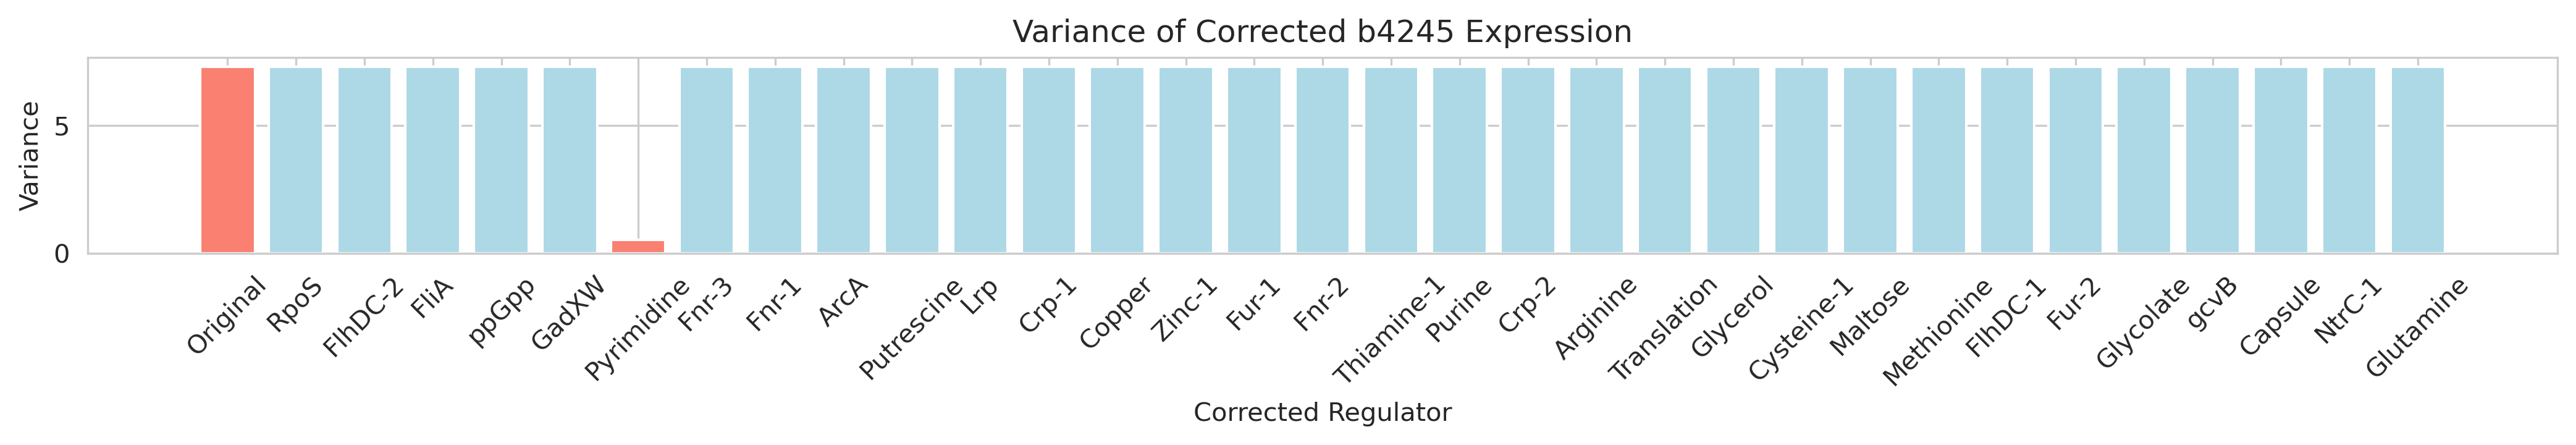

b4245 - Original Expression Values


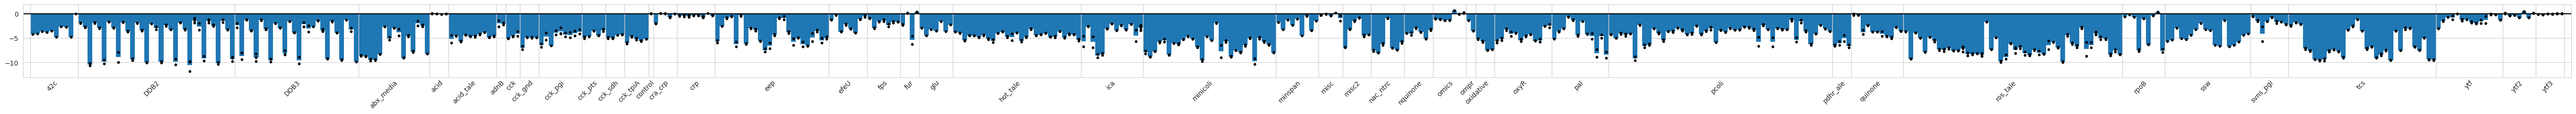

b4245 - Adjusted Expression Values


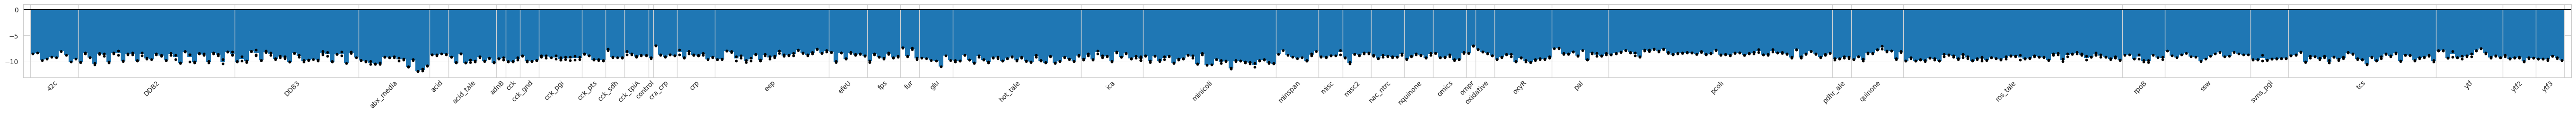

In [ ]:
gene_cur = 'b4245'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

#### b1073 - flgB

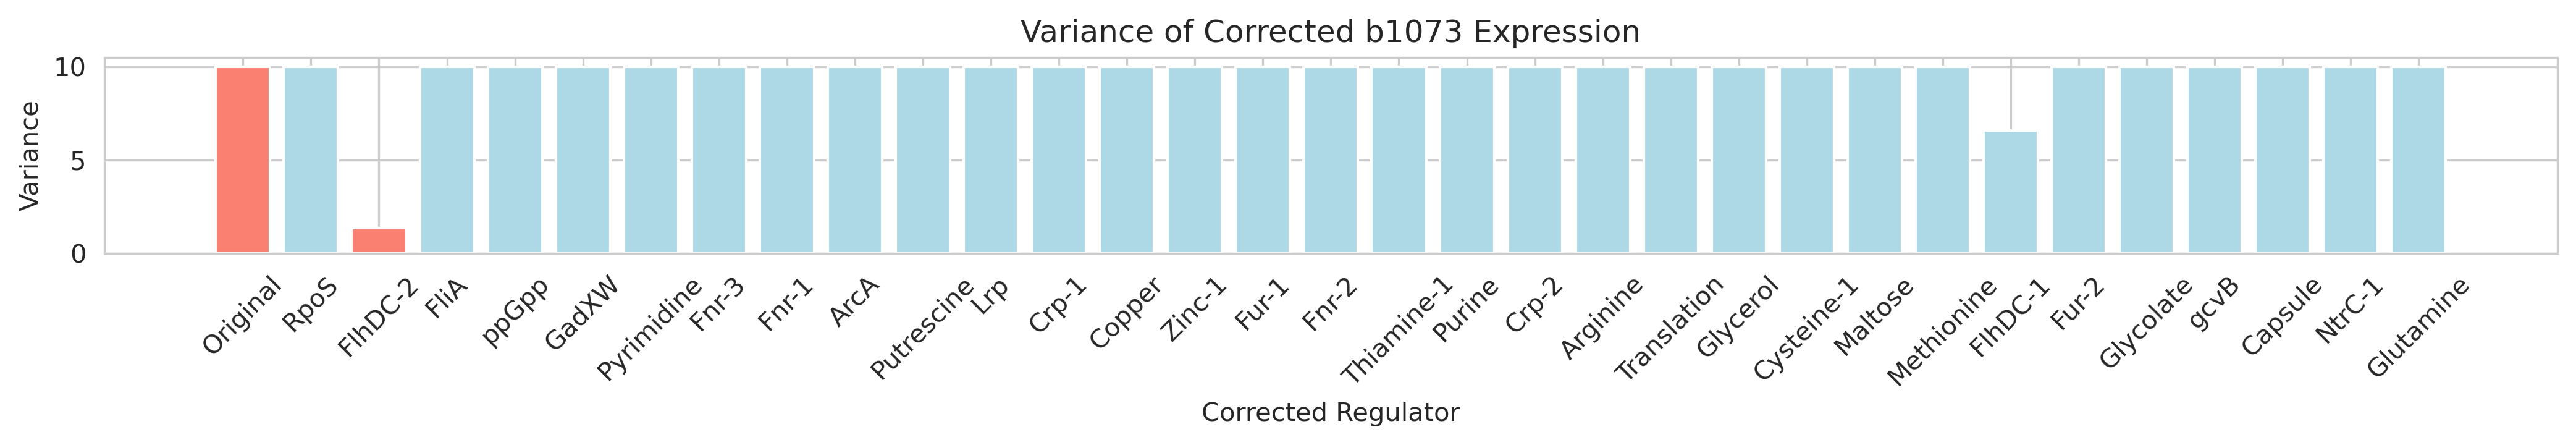

b1073 - Original Expression Values


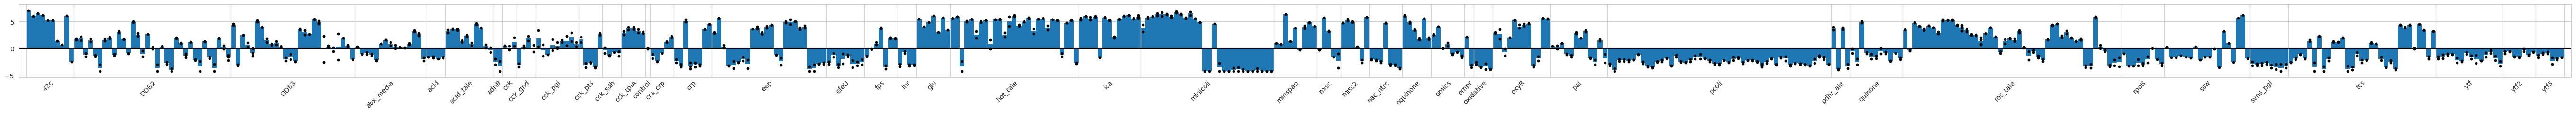

b1073 - Adjusted Expression Values


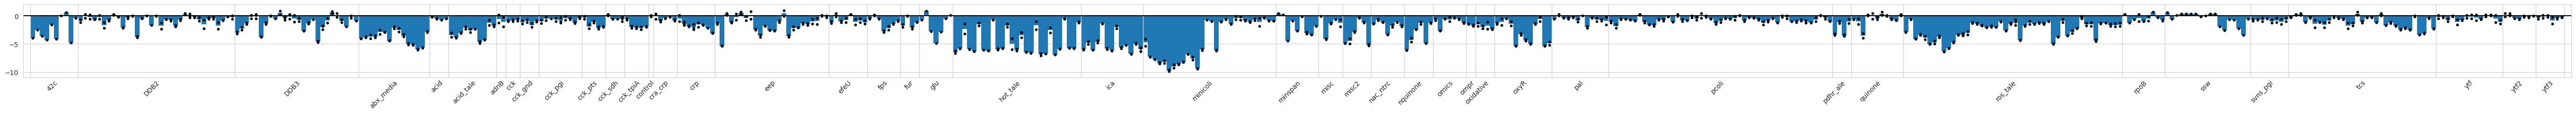

In [ ]:
gene_cur = 'b1073'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show() 

#### b3555 - yiaG

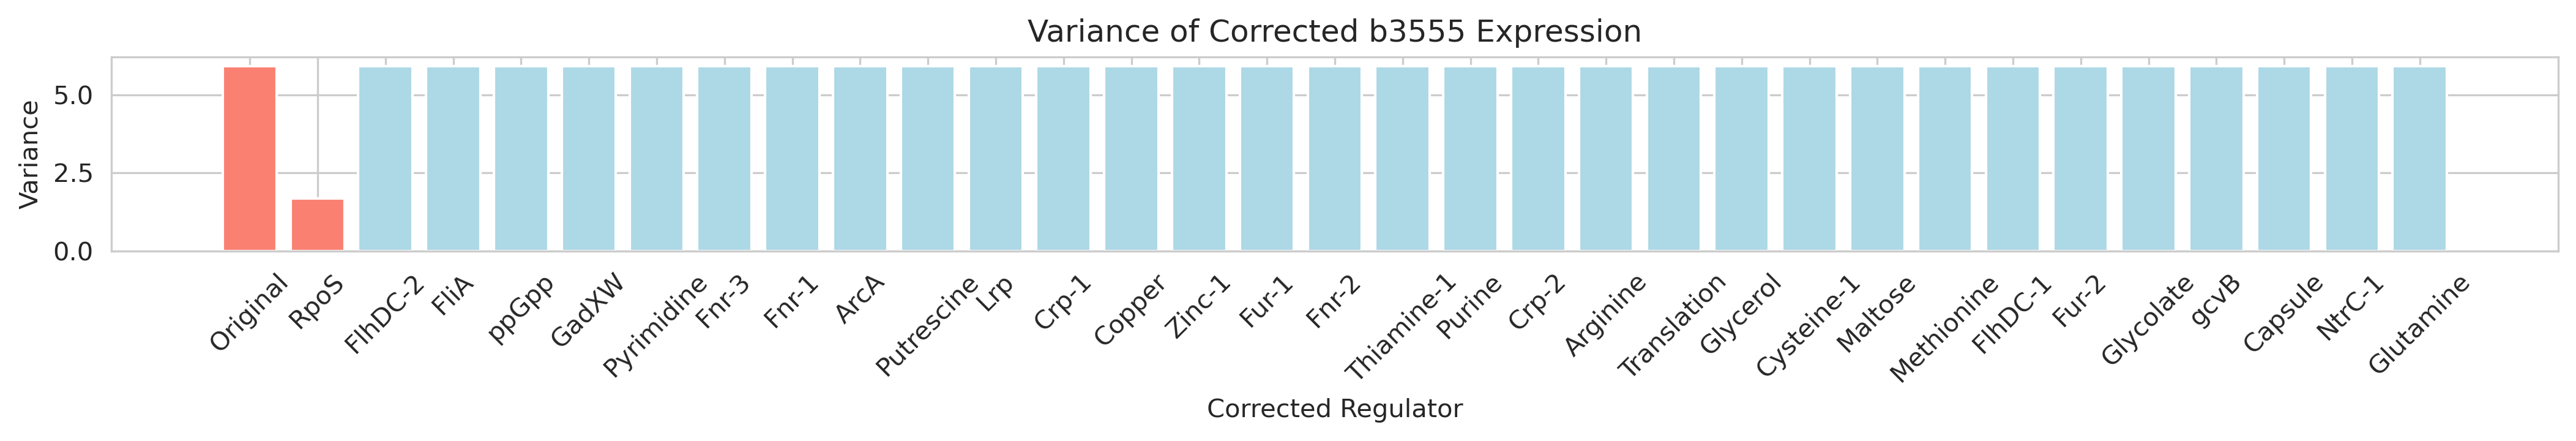

b3555 - Original Expression Values


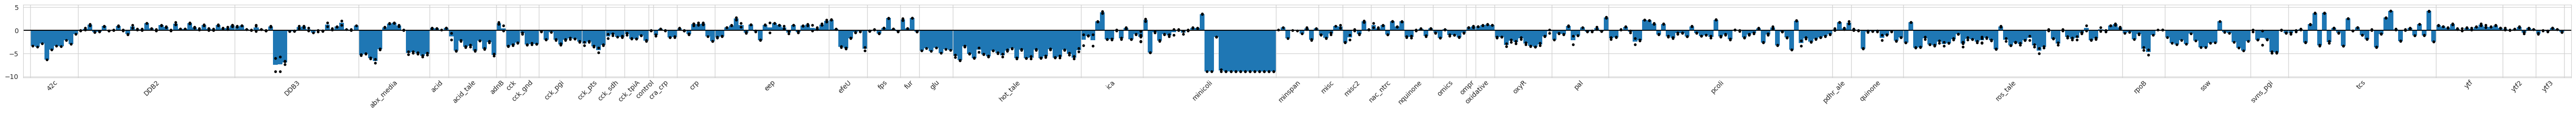

b3555 - Adjusted Expression Values


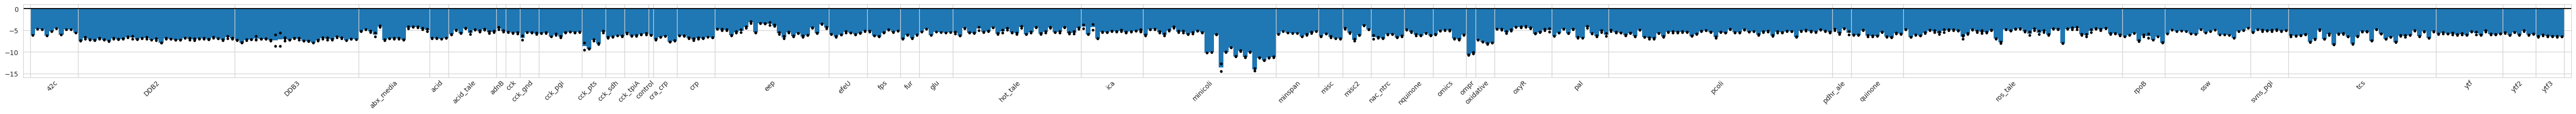

In [ ]:
gene_cur = 'b3555'

plot_gene_variance(accumulated_changes_dict, precise1k.X, gene_cur)

expr_cur = precise1k.X.loc[gene_cur]
expr_corr_adj = PRECISE_1K_X_basal.loc[gene_cur]

# Plot before and after adjustment
print(f"{gene_cur} - Original Expression Values")
barplot(values=expr_cur, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()
    
print(f"{gene_cur} - Adjusted Expression Values")
barplot(values=expr_corr_adj, sample_table=precise1k.sample_table)
plt.gcf().canvas.draw()
plt.show()

### Overall distribution of original X and adjusted X

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataframe_distribution(df, lower_bound=-20, upper_bound=100):
 
    # Flatten the DataFrame to get all elements as a single series
    all_elements = df.to_numpy().flatten()

    # Limiting the elements to the specified range
    all_elements = all_elements[(all_elements >= lower_bound) & (all_elements <= upper_bound)]

    # Create the distribution plot
    plt.figure(figsize=(6, 4))
    sns.histplot(all_elements, bins=30, kde=True)
    plt.title("Distribution of X matrix")
    plt.xlabel("log TPM")
    plt.ylabel("Frequency")
    plt.show()

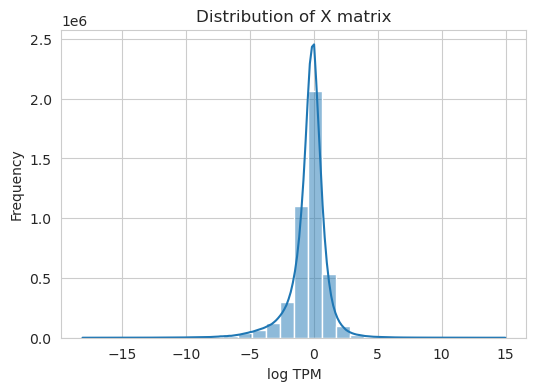

In [ ]:
plot_dataframe_distribution(PRECISE_1K_X_basal)

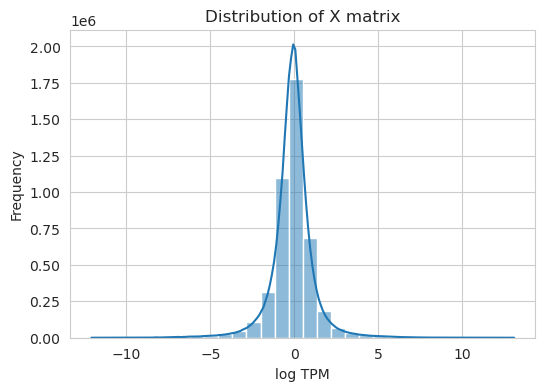

In [ ]:
plot_dataframe_distribution(precise1k.X)

## Reconstruction of A based on adjusted X and original M

### Check the activities of adjusted iMs

In [ ]:
PRECISE_1K_A = precise1k.A

In [ ]:
PRECISE_1K_A_reconstructed = (np.linalg.pinv(PRECISE_1K_M)).dot(PRECISE_1K_X_basal)

# Convert the numpy array back to pandas DataFrame
PRECISE_1K_A_reconstructed = pd.DataFrame(PRECISE_1K_A_reconstructed, columns=PRECISE_1K_A.columns, index=PRECISE_1K_A.index)

In [ ]:
PRECISE_1K_A_reconstructed_min_max_median = min_max_median(PRECISE_1K_A_reconstructed)

In [ ]:
PRECISE_1K_A_reconstructed_min_max_median

Min        Max     Median  p1k_00001
Fur-1      -21.430182  38.089373  15.092105  10.593273
FlhDC-1    -27.724145  13.556242   5.367170   7.219059
Cysteine-1 -15.878541  48.407564   3.425099   4.289362
Thiamine-1  -6.888161  40.367942   5.649978   3.510011
Arginine   -18.231672  37.098049   8.312784   2.833633
...               ...        ...        ...        ...
Fur-2      -18.784635  -7.752616 -11.251769 -10.692724
Copper     -14.816684 -11.992969 -13.050691 -12.979625
Pyrimidine -21.165677 -13.078604 -16.667369 -13.714371
GadXW      -17.821424 -12.036074 -15.757238 -14.818190
RpoS       -32.998568 -21.128264 -26.963379 -25.998163

[201 rows x 4 columns]

In [ ]:
PRECISE_1K_A_reconstructed_min_max_median.to_csv('./Data_Basal_Expression/Reconstructed_A_from_basal_X_min_max_glucose.csv')

In [ ]:
def plot_row_distribution(df, row_index, lower_bound=-50, upper_bound=100):

    # Get the row by index
    row_values = df.loc[row_index]

    # Limiting the elements to the specified range
    row_values = row_values[(row_values >= lower_bound) & (row_values <= upper_bound)]

    # Create the distribution plot
    plt.figure(figsize=(6, 4))
    sns.histplot(row_values, bins=30, kde=True)
    plt.title(f"Distribution of iM {row_index}")
    plt.xlabel("Activities")
    plt.ylabel("Frequency")
    plt.show()

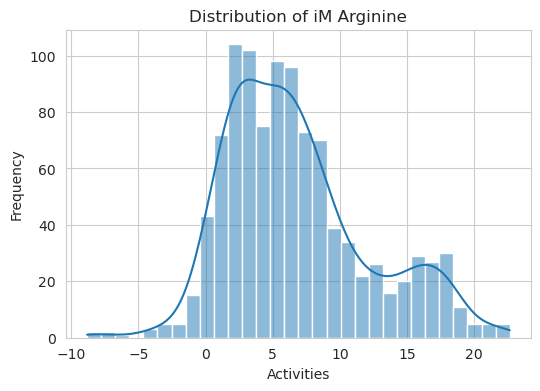

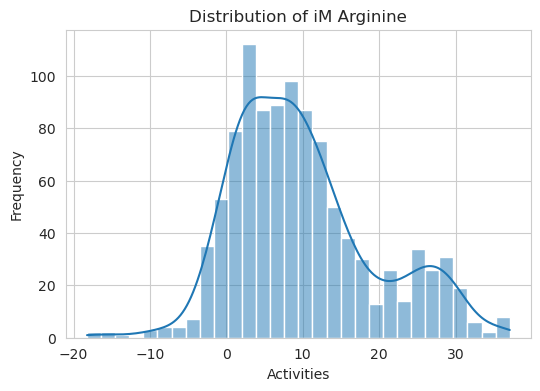

In [ ]:
iM = 'Arginine'
plot_row_distribution(PRECISE_1K_A, iM)
plot_row_distribution(PRECISE_1K_A_reconstructed, iM)

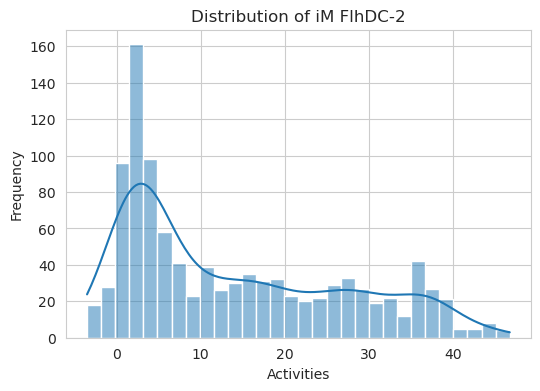

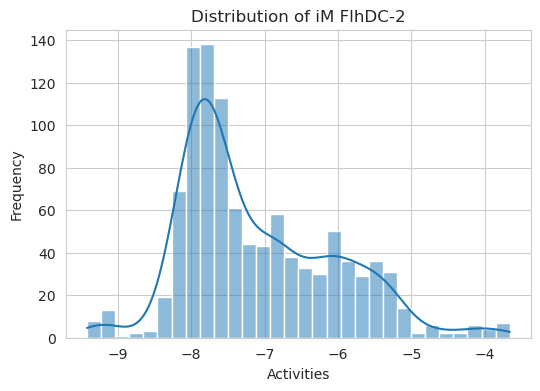

In [ ]:
iM = 'FlhDC-2'
plot_row_distribution(PRECISE_1K_A, iM)
plot_row_distribution(PRECISE_1K_A_reconstructed, iM)

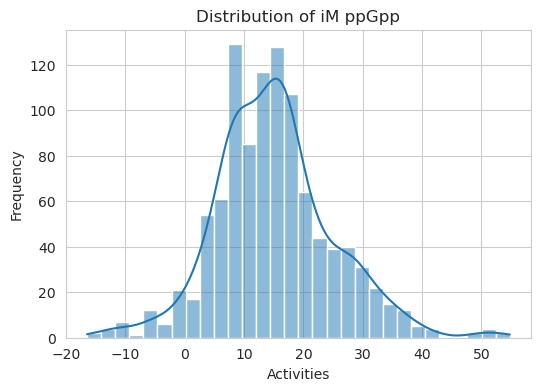

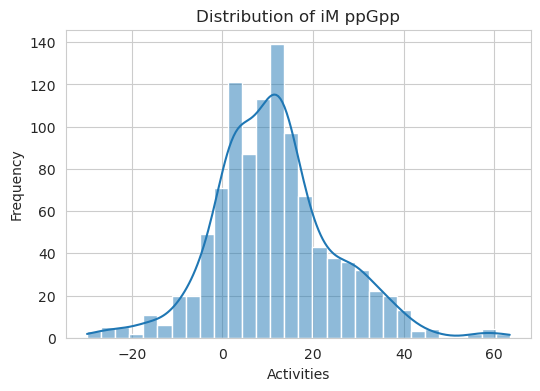

In [ ]:
iM = 'ppGpp'
plot_row_distribution(PRECISE_1K_A, iM)
plot_row_distribution(PRECISE_1K_A_reconstructed, iM)

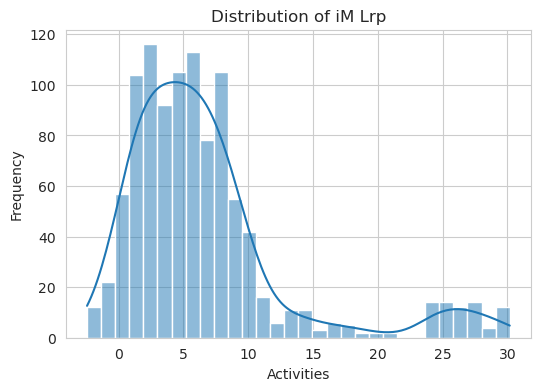

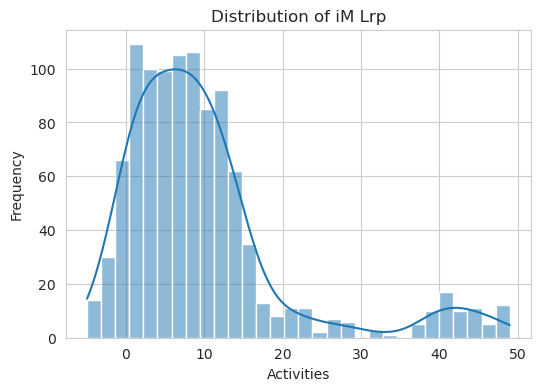

In [ ]:
iM = 'Lrp'
plot_row_distribution(PRECISE_1K_A, iM)
plot_row_distribution(PRECISE_1K_A_reconstructed, iM)

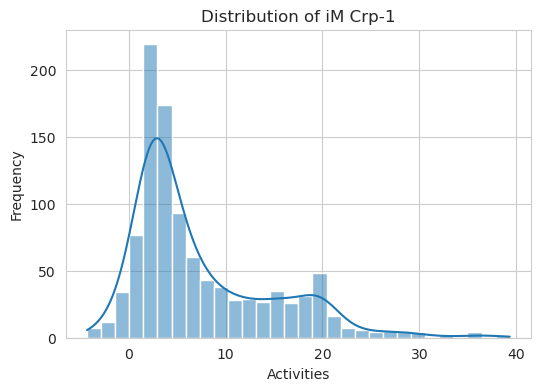

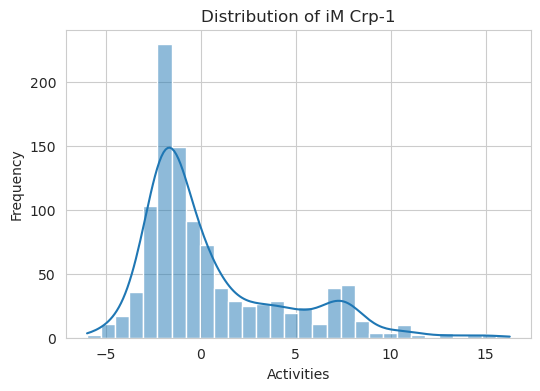

In [ ]:
iM = 'Crp-1'
plot_row_distribution(PRECISE_1K_A, iM)
plot_row_distribution(PRECISE_1K_A_reconstructed, iM)